In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import functools
import torchsde
from collections import namedtuple
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms

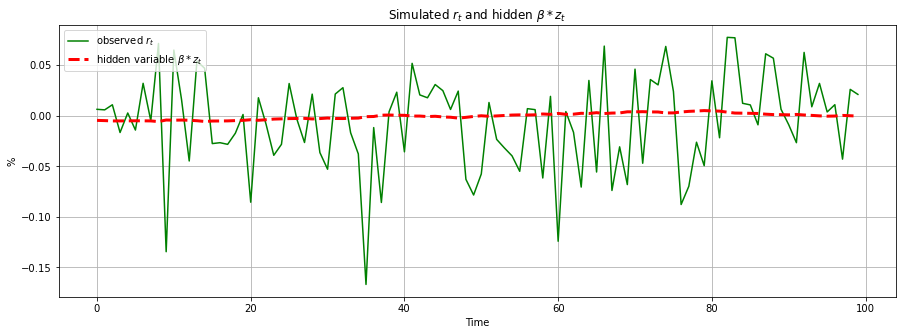

In [44]:
latent_dim = 1
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
batch_size=1000
T = 100
Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])
def generate_timeseries(nsample=100,
                      ):
    
    beta = 0.1694
    phi = 0.9805
    sigma_v = 0.003342
    sigma_u = 0.0528
    rho = -0.856
    cov_uv = rho * sigma_u * sigma_v

    # generating shocks
    mu = [0,0]
    cov = [[sigma_u**2, cov_uv], [cov_uv, sigma_v**2]]
    shocks = np.random.multivariate_normal(mu, cov, T)

    z0 = np.random.normal(0, sigma_u**2/(1-phi**2),1)
    r0 = shocks[0][0]

    z = np.zeros(T)
    r = np.zeros(T)
    z[0] = z0
    r[0] = r0
    
    
    for idx_t in range(T-1):
        z[idx_t+1] = phi*z[idx_t] + shocks[idx_t+1][1]
        r[idx_t+1] = beta*z[idx_t] + shocks[idx_t+1][0]
    time_series = np.stack((r,np.array(range(T))),axis=1)
    plt.figure(figsize=(15,5))
    xvalues = np.array(range(T))
    plt.plot(xvalues, r, linestyle='-', color='g', label="observed $r_t$")
    plt.plot(xvalues, beta*z, linestyle="--", color="r", label=r"hidden variable $\beta * z_t$", linewidth=3.0)

    plt.legend(loc="upper left")
    plt.xlabel('Time')
    plt.ylabel('%')
    plt.grid(True)
    plt.title(r"Simulated $r_t$ and hidden $\beta * z_t$")
    plt.show()

    
    return r, z, time_series, xvalues
r,z,time_series, ts = generate_timeseries()

In [45]:
time_series.shape

(100, 2)

In [46]:
class Time_Series(Dataset):
            
    def __init__(self, time_series,transform=None):
        self.data = time_series
        self.transform = transform
        
    def __getitem__(self,index):
        
        #image = Image.fromarray(image.squeeze(), mode="RGB")
        return self.data[index], 0
        
    def __len__(self):
        return len(self.data)

In [47]:
batch_size = 10
dataset = Time_Series(time_series, transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# define a time-dependent score-based model

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [49]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [50]:
class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        print(x)
        return self.dense(x)

代码跟mnist的一摸一样，dimension方面改了，并且score net改成了普通的MLP

In [51]:
class ScoreNet(nn.Module):
    def __init__(self, marginal_prob_std, embed_dim=256):
        '''
        initial a time-dependent score-based network
        
        Args:
            marginal_prob_std: A function that takes time t and gives the standard deviation of the perturbation kernel p_{0t}(x(t)|x(0))
            channels: The number of channels for feature maps of each resolution. 
            embed_dim: The dimensionality of Gaussian random feature embeddings
        
        '''
        super().__init__()
        # gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                  nn.Linear(embed_dim, embed_dim))
        self.l1 = nn.Linear(2,200)
        self.dense1 = Dense(embed_dim,200)
        self.l2 = nn.Linear(200,200)
        self.dense2 = Dense(embed_dim,200)
        self.l3 = nn.Linear(200,1)
        self.dense3 = Dense(embed_dim,1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        
    def forward(self, x, t): 
        embed = self.act(self.embed(t))  
        h = self.l1(x)    
        ## Incorporate information from t
        h += self.dense1(embed)
        h = self.l2(h)
        h += self.dense2(embed)
        h = self.l3(h)
        h += self.dense3(embed)
        
        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None]
        return h

# Training with Weighted Sum of Denoising Score Matching Objectives

1. we need to specify an SDE that perturbs the data distribution $p_0$ to a prior distribution $p_T$. We choose the following SDE
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}
In this case,
\begin{align*}
p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) = \mathcal{N}\bigg(\mathbf{x}(t); \mathbf{x}(0), \frac{1}{2\log \sigma}(\sigma^{2t} - 1) \mathbf{I}\bigg)
\end{align*}
and we can choose the weighting function $\lambda(t) = \frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$.

When $\sigma$ is large, the prior distribution, $p_{t=1}$ is 
\begin{align*}
\int p_0(\mathbf{y})\mathcal{N}\bigg(\mathbf{x}; \mathbf{y}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg) d \mathbf{y} \approx \mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg),
\end{align*}
which is approximately independent of the data distribution and is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_0$ to a simple Gaussian distribution $p_1$.

### set up the SDE

In [52]:
def marginal_prob_std(t, sigma):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2*t)-1.)/2./np.log(sigma))

def diffusion_coeff(t, sigma): # compute the diffusion coefficient of our SDE
    return torch.tensor(sigma**t, device=device)
sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

### define the loss function

In [53]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5): # the loss function for training score-based generative model
    random_t = torch.rand(x.shape[0], device=x.device)*(1.-eps)+eps #随机创建几个时间t
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t) #得到 std
    perturbed_x = x + z *std[:,None] #通过sde得到perturbed 的数据，x(t) from marginal_prob_std
    score = model(perturbed_x, random_t) # s(x(t),t)
    loss = torch.mean(torch.sum((score*std[:,None]+z)**2,dim=(1)))
    return loss

### Training

In [54]:
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm

In [55]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 50

lr = 1e-4


optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in data_loader:
        x = x.float().to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # print the averaged training loss so far
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss/num_items))
    # update the checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'ckpt_time_series.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\15197\AppData\Local\Temp/ipykernel_2524/3839170210.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


tensor([[-0.1615,  0.0022, -0.1262,  ..., -0.0657,  0.0432, -0.2373],
        [-0.2081, -0.1169,  0.0205,  ...,  0.7313,  0.7215,  0.5209],
        [-0.0511, -0.1819,  0.6062,  ..., -0.2764, -0.0996,  0.3598],
        ...,
        [ 0.2926, -0.1194, -0.1174,  ...,  0.4324,  0.0736,  0.0943],
        [ 0.3169,  0.0747, -0.2451,  ...,  0.2637, -0.1776, -0.0585],
        [ 0.4283,  0.0016,  0.1615,  ...,  0.1342,  0.3442, -0.2387]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1615,  0.0022, -0.1262,  ..., -0.0657,  0.0432, -0.2373],
        [-0.2081, -0.1169,  0.0205,  ...,  0.7313,  0.7215,  0.5209],
        [-0.0511, -0.1819,  0.6062,  ..., -0.2764, -0.0996,  0.3598],
        ...,
        [ 0.2926, -0.1194, -0.1174,  ...,  0.4324,  0.0736,  0.0943],
        [ 0.3169,  0.0747, -0.2451,  ...,  0.2637, -0.1776, -0.0585],
        [ 0.4283,  0.0016,  0.1615,  ...,  0.1342,  0.3442, -0.2387]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1615,  0.0022, -0.1262, 

tensor([[ 0.1431,  0.6615, -0.0165,  ...,  0.0491,  0.0207, -0.1475],
        [ 0.6140,  0.4205,  0.0712,  ..., -0.0566,  0.0167,  0.0407],
        [ 0.1598, -0.1893, -0.1329,  ..., -0.2296, -0.2029, -0.1575],
        ...,
        [ 0.4783, -0.0446, -0.1333,  ...,  0.2463,  0.1397,  0.0418],
        [-0.1160,  0.4217, -0.0432,  ..., -0.1769,  0.3120, -0.0045],
        [ 0.0386, -0.2115,  0.1530,  ...,  0.3135,  0.1987, -0.1862]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.1431,  0.6615, -0.0165,  ...,  0.0491,  0.0207, -0.1475],
        [ 0.6140,  0.4205,  0.0712,  ..., -0.0566,  0.0167,  0.0407],
        [ 0.1598, -0.1893, -0.1329,  ..., -0.2296, -0.2029, -0.1575],
        ...,
        [ 0.4783, -0.0446, -0.1333,  ...,  0.2463,  0.1397,  0.0418],
        [-0.1160,  0.4217, -0.0432,  ..., -0.1769,  0.3120, -0.0045],
        [ 0.0386, -0.2115,  0.1530,  ...,  0.3135,  0.1987, -0.1862]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.4908, -0.0464,  0.0956, 

tensor([[ 0.4979, -0.0824, -0.0242,  ..., -0.0213, -0.1969, -0.0868],
        [-0.1399, -0.2383,  0.5007,  ...,  0.3117, -0.0512, -0.1432],
        [ 0.0382,  0.0513,  1.2124,  ..., -0.2053, -0.1096,  0.2832],
        ...,
        [ 0.4256,  0.1431,  0.1788,  ...,  0.1567, -0.1680, -0.0771],
        [ 0.2068, -0.1732,  0.3872,  ...,  0.0632,  0.1602, -0.0704],
        [ 0.4270,  0.3937,  0.1530,  ..., -0.0955, -0.0143,  0.4902]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.4979, -0.0824, -0.0242,  ..., -0.0213, -0.1969, -0.0868],
        [-0.1399, -0.2383,  0.5007,  ...,  0.3117, -0.0512, -0.1432],
        [ 0.0382,  0.0513,  1.2124,  ..., -0.2053, -0.1096,  0.2832],
        ...,
        [ 0.4256,  0.1431,  0.1788,  ...,  0.1567, -0.1680, -0.0771],
        [ 0.2068, -0.1732,  0.3872,  ...,  0.0632,  0.1602, -0.0704],
        [ 0.4270,  0.3937,  0.1530,  ..., -0.0955, -0.0143,  0.4902]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.4979, -0.0824, -0.0242, 

tensor([[-0.2173, -0.1311, -0.1381,  ..., -0.0115, -0.0917,  0.4932],
        [-0.2408, -0.0741, -0.0668,  ...,  0.0723,  0.0805, -0.0805],
        [ 0.0464, -0.1139,  0.0782,  ...,  0.1336,  0.3014, -0.1942],
        ...,
        [-0.2692, -0.0261, -0.1699,  ...,  0.0197,  0.0714,  0.0485],
        [ 0.0068,  0.0303, -0.0616,  ..., -0.1788,  0.0249,  0.3334],
        [-0.1306, -0.1430, -0.1849,  ..., -0.0427,  0.6753,  0.2063]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.2173, -0.1311, -0.1381,  ..., -0.0115, -0.0917,  0.4932],
        [-0.2408, -0.0741, -0.0668,  ...,  0.0723,  0.0805, -0.0805],
        [ 0.0464, -0.1139,  0.0782,  ...,  0.1336,  0.3014, -0.1942],
        ...,
        [-0.2692, -0.0261, -0.1699,  ...,  0.0197,  0.0714,  0.0485],
        [ 0.0068,  0.0303, -0.0616,  ..., -0.1788,  0.0249,  0.3334],
        [-0.1306, -0.1430, -0.1849,  ..., -0.0427,  0.6753,  0.2063]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0810, -0.0553, -0.1591, 

tensor([[-0.1346, -0.1266, -0.1779,  ..., -0.0820, -0.0910, -0.1826],
        [-0.1114, -0.2424,  0.2887,  ..., -0.0334,  0.1135,  0.4343],
        [ 0.0265, -0.0981, -0.2745,  ...,  0.0643, -0.0631, -0.1609],
        ...,
        [-0.2033,  0.0724,  0.3007,  ...,  0.0734, -0.1501, -0.0779],
        [ 0.1990, -0.0529, -0.1536,  ..., -0.1647, -0.2380,  0.0975],
        [-0.1941, -0.2747,  0.2739,  ..., -0.0144,  0.2609, -0.0154]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1346, -0.1266, -0.1779,  ..., -0.0820, -0.0910, -0.1826],
        [-0.1114, -0.2424,  0.2887,  ..., -0.0334,  0.1135,  0.4343],
        [ 0.0265, -0.0981, -0.2745,  ...,  0.0643, -0.0631, -0.1609],
        ...,
        [-0.2033,  0.0724,  0.3007,  ...,  0.0734, -0.1501, -0.0779],
        [ 0.1990, -0.0529, -0.1536,  ..., -0.1647, -0.2380,  0.0975],
        [-0.1941, -0.2747,  0.2739,  ..., -0.0144,  0.2609, -0.0154]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1346, -0.1266, -0.1779, 

tensor([[ 0.2474,  0.1451,  0.0919,  ..., -0.1367,  0.3020,  0.1009],
        [-0.1686,  0.3218, -0.1917,  ...,  0.3287, -0.0651, -0.2511],
        [ 0.2845,  0.2543,  0.2547,  ..., -0.1684,  0.2748, -0.1164],
        ...,
        [ 0.2781, -0.0648,  0.0323,  ...,  0.2573,  0.2488, -0.0683],
        [ 0.2412, -0.1864,  0.1557,  ...,  0.0985, -0.0960, -0.1418],
        [-0.0237, -0.0208, -0.0517,  ..., -0.1721,  0.0915,  0.2652]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.2474,  0.1451,  0.0919,  ..., -0.1367,  0.3020,  0.1009],
        [-0.1686,  0.3218, -0.1917,  ...,  0.3287, -0.0651, -0.2511],
        [ 0.2845,  0.2543,  0.2547,  ..., -0.1684,  0.2748, -0.1164],
        ...,
        [ 0.2781, -0.0648,  0.0323,  ...,  0.2573,  0.2488, -0.0683],
        [ 0.2412, -0.1864,  0.1557,  ...,  0.0985, -0.0960, -0.1418],
        [-0.0237, -0.0208, -0.0517,  ..., -0.1721,  0.0915,  0.2652]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.6046,  0.2240, -0.0536, 

tensor([[-0.1357,  0.3682, -0.0406,  ..., -0.1636,  0.3268,  0.0023],
        [ 0.1577, -0.2202, -0.1174,  ...,  0.0639, -0.0224,  0.6753],
        [ 0.3447, -0.1360, -0.0743,  ..., -0.0912,  0.2450, -0.2236],
        ...,
        [-0.0771, -0.0016,  0.0944,  ..., -0.0868,  0.2710, -0.0692],
        [ 0.0573,  0.1066, -0.1403,  ...,  0.2621,  0.1043,  0.0115],
        [ 0.9463, -0.1275,  0.0490,  ...,  0.1951,  0.0513,  0.0614]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1357,  0.3682, -0.0406,  ..., -0.1636,  0.3268,  0.0023],
        [ 0.1577, -0.2202, -0.1174,  ...,  0.0639, -0.0224,  0.6753],
        [ 0.3447, -0.1360, -0.0743,  ..., -0.0912,  0.2450, -0.2236],
        ...,
        [-0.0771, -0.0016,  0.0944,  ..., -0.0868,  0.2710, -0.0692],
        [ 0.0573,  0.1066, -0.1403,  ...,  0.2621,  0.1043,  0.0115],
        [ 0.9463, -0.1275,  0.0490,  ...,  0.1951,  0.0513,  0.0614]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.1794, -0.2661, -0.1388, 

tensor([[ 0.9464, -0.1450, -0.1469,  ...,  0.0239, -0.0769, -0.0244],
        [ 0.0436,  0.0361, -0.1915,  ..., -0.1321,  0.7883, -0.1235],
        [-0.1803, -0.0068,  0.5208,  ..., -0.2685, -0.0963,  0.3644],
        ...,
        [ 0.4254, -0.0941,  0.0705,  ...,  0.0510,  0.0584,  0.3739],
        [ 0.4085,  0.2169, -0.2002,  ...,  0.4986, -0.1949,  0.3103],
        [-0.1414,  0.1789,  0.2143,  ...,  0.1856,  0.3700, -0.2396]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.9464, -0.1450, -0.1469,  ...,  0.0239, -0.0769, -0.0244],
        [ 0.0436,  0.0361, -0.1915,  ..., -0.1321,  0.7883, -0.1235],
        [-0.1803, -0.0068,  0.5208,  ..., -0.2685, -0.0963,  0.3644],
        ...,
        [ 0.4254, -0.0941,  0.0705,  ...,  0.0510,  0.0584,  0.3739],
        [ 0.4085,  0.2169, -0.2002,  ...,  0.4986, -0.1949,  0.3103],
        [-0.1414,  0.1789,  0.2143,  ...,  0.1856,  0.3700, -0.2396]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.4221, -0.2030,  0.1104, 

tensor([[ 0.2109,  0.2458,  0.0605,  ..., -0.1450,  0.4166, -0.0851],
        [-0.1883, -0.1651,  0.3204,  ..., -0.1627,  0.1801, -0.0397],
        [-0.0690, -0.2403,  0.1960,  ..., -0.0714,  0.2027,  0.3543],
        ...,
        [ 0.4860, -0.0674, -0.0160,  ..., -0.0027, -0.2057, -0.0674],
        [ 0.3967,  0.0998,  0.2172,  ..., -0.1447,  0.1712,  0.4041],
        [ 0.5252,  0.4079, -0.2127,  ...,  0.3715, -0.2463,  0.3167]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.2109,  0.2458,  0.0605,  ..., -0.1450,  0.4166, -0.0851],
        [-0.1883, -0.1651,  0.3204,  ..., -0.1627,  0.1801, -0.0397],
        [-0.0690, -0.2403,  0.1960,  ..., -0.0714,  0.2027,  0.3543],
        ...,
        [ 0.4860, -0.0674, -0.0160,  ..., -0.0027, -0.2057, -0.0674],
        [ 0.3967,  0.0998,  0.2172,  ..., -0.1447,  0.1712,  0.4041],
        [ 0.5252,  0.4079, -0.2127,  ...,  0.3715, -0.2463,  0.3167]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1048, -0.0875, -0.1214, 

tensor([[-0.1107, -0.1723, -0.0454,  ..., -0.1077, -0.2005,  0.0915],
        [-0.1264, -0.0218, -0.1741,  ..., -0.0568, -0.2145,  0.0054],
        [ 0.1759, -0.0881,  0.1041,  ..., -0.1405,  0.5435,  0.5493],
        ...,
        [-0.2224,  0.0750, -0.2087,  ..., -0.0495, -0.2316, -0.1190],
        [-0.1296, -0.1022, -0.1705,  ..., -0.0700, -0.0960, -0.1276],
        [ 0.5387, -0.1622, -0.0432,  ...,  0.1471,  0.3679, -0.1608]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0856,  0.4802,  0.2814,  ..., -0.2016, -0.1216, -0.1239],
        [ 0.8949, -0.1462, -0.1495,  ...,  0.0013, -0.0648, -0.0179],
        [-0.1449, -0.0730,  0.3575,  ..., -0.1023,  0.3525, -0.1873],
        ...,
        [-0.2780, -0.2088, -0.0907,  ..., -0.0894,  0.0391,  0.0821],
        [-0.1286, -0.0883, -0.1586,  ..., -0.0850,  0.4807,  0.3509],
        [-0.1137, -0.1775,  0.2250,  ..., -0.1983,  0.1678,  0.0118]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0856,  0.4802,  0.2814, 

tensor([[ 0.0103, -0.0802, -0.2428,  ..., -0.2067, -0.0245, -0.0343],
        [-0.0192, -0.0025, -0.0542,  ..., -0.1727,  0.0701,  0.2896],
        [ 0.1237,  0.0924,  1.1439,  ..., -0.1613, -0.1467,  0.3293],
        ...,
        [-0.2737, -0.2020, -0.0500,  ..., -0.1146, -0.0410,  0.0624],
        [ 0.1121, -0.1731,  0.0621,  ...,  0.3985,  0.0332, -0.1323],
        [-0.1664, -0.0342,  0.2185,  ...,  0.3952,  0.3281, -0.0058]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0934,  0.2519, -0.1090,  ..., -0.0430, -0.1962, -0.2280],
        [ 0.2418, -0.1047,  0.0783,  ..., -0.1374,  0.5009,  0.5796],
        [-0.1133, -0.2441,  0.2960,  ..., -0.0323,  0.0939,  0.4539],
        ...,
        [-0.1905, -0.1015, -0.0252,  ..., -0.1284,  0.2744, -0.0222],
        [-0.2012,  0.2540, -0.1304,  ...,  0.1121, -0.0014, -0.0022],
        [ 0.0302, -0.2196,  0.0176,  ..., -0.0818,  0.0138,  0.7427]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0934,  0.2519, -0.1090, 

tensor([[ 0.0969,  0.0904,  1.2201,  ..., -0.1780, -0.1413,  0.3273],
        [ 0.1879, -0.1680,  0.3856,  ...,  0.0696,  0.1478, -0.0410],
        [-0.0436, -0.0450, -0.1447,  ..., -0.0685, -0.0981,  0.0937],
        ...,
        [-0.0100, -0.1975,  0.1219,  ..., -0.1809, -0.0191,  0.5343],
        [ 0.3823, -0.0707, -0.0215,  ...,  0.2344,  0.1597,  0.0425],
        [ 0.1851, -0.1099, -0.0890,  ...,  0.4418,  0.2248,  0.0374]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0969,  0.0904,  1.2201,  ..., -0.1780, -0.1413,  0.3273],
        [ 0.1879, -0.1680,  0.3856,  ...,  0.0696,  0.1478, -0.0410],
        [-0.0436, -0.0450, -0.1447,  ..., -0.0685, -0.0981,  0.0937],
        ...,
        [-0.0100, -0.1975,  0.1219,  ..., -0.1809, -0.0191,  0.5343],
        [ 0.3823, -0.0707, -0.0215,  ...,  0.2344,  0.1597,  0.0425],
        [ 0.1851, -0.1099, -0.0890,  ...,  0.4418,  0.2248,  0.0374]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.5786,  0.0786, -0.0080, 

tensor([[ 0.1522, -0.0969, -0.1509,  ..., -0.1801, -0.2255,  0.0782],
        [-0.1669, -0.0205, -0.2648,  ...,  0.0365, -0.1794,  0.0207],
        [ 0.1361, -0.0408,  0.0473,  ...,  0.4310, -0.0970, -0.0090],
        ...,
        [-0.1315, -0.2190,  0.0576,  ...,  0.7247,  0.2612,  0.0785],
        [-0.2023,  0.0557,  0.2880,  ...,  0.0087, -0.0210, -0.0584],
        [ 0.1363, -0.0714,  0.3743,  ..., -0.1269,  0.2720,  0.1646]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.1522, -0.0969, -0.1509,  ..., -0.1801, -0.2255,  0.0782],
        [-0.1669, -0.0205, -0.2648,  ...,  0.0365, -0.1794,  0.0207],
        [ 0.1361, -0.0408,  0.0473,  ...,  0.4310, -0.0970, -0.0090],
        ...,
        [-0.1315, -0.2190,  0.0576,  ...,  0.7247,  0.2612,  0.0785],
        [-0.2023,  0.0557,  0.2880,  ...,  0.0087, -0.0210, -0.0584],
        [ 0.1363, -0.0714,  0.3743,  ..., -0.1269,  0.2720,  0.1646]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.4186,  0.1172,  0.2260, 

tensor([[ 0.1117,  0.2087,  0.6433,  ...,  0.3799, -0.2070, -0.1975],
        [ 1.0971, -0.1573, -0.0018,  ...,  0.1772,  0.2491,  0.1038],
        [-0.0387,  0.4014, -0.0690,  ...,  0.1494, -0.0058, -0.0562],
        ...,
        [-0.0134, -0.2736, -0.0725,  ...,  0.0618, -0.0400,  0.1203],
        [ 0.3163, -0.1287, -0.0591,  ..., -0.0640,  0.2621, -0.2227],
        [-0.2112, -0.0903,  0.0797,  ..., -0.0346, -0.0888,  0.1176]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.2685, -0.1564, -0.0820,  ..., -0.0293, -0.1579, -0.0185],
        [ 0.1048,  0.0316,  0.1021,  ...,  0.2375,  0.4579,  0.2760],
        [-0.0294, -0.0550,  0.1195,  ..., -0.0025,  0.0839,  0.0051],
        ...,
        [ 0.0680, -0.1009, -0.1670,  ..., -0.2127, -0.1979, -0.2188],
        [-0.1321, -0.2737, -0.1353,  ...,  0.1599,  0.0579, -0.1365],
        [ 0.5178, -0.0284, -0.1834,  ...,  0.2629,  0.1222,  0.0116]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.2685, -0.1564, -0.0820, 

tensor([[-0.1199, -0.2689,  0.0193,  ...,  0.2172, -0.0480,  0.1169],
        [-0.2031,  0.0754,  0.3056,  ...,  0.0645, -0.1404, -0.0778],
        [ 0.2118, -0.2299, -0.1397,  ..., -0.2128, -0.1742, -0.0922],
        ...,
        [ 0.3146,  0.0791,  0.0675,  ...,  0.1309, -0.2399,  0.2087],
        [-0.0259, -0.0542,  0.1470,  ..., -0.0095,  0.1690, -0.0319],
        [-0.0171, -0.1798,  0.4285,  ..., -0.0240,  0.3481, -0.0715]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1199, -0.2689,  0.0193,  ...,  0.2172, -0.0480,  0.1169],
        [-0.2031,  0.0754,  0.3056,  ...,  0.0645, -0.1404, -0.0778],
        [ 0.2118, -0.2299, -0.1397,  ..., -0.2128, -0.1742, -0.0922],
        ...,
        [ 0.3146,  0.0791,  0.0675,  ...,  0.1309, -0.2399,  0.2087],
        [-0.0259, -0.0542,  0.1470,  ..., -0.0095,  0.1690, -0.0319],
        [-0.0171, -0.1798,  0.4285,  ..., -0.0240,  0.3481, -0.0715]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1199, -0.2689,  0.0193, 

tensor([[ 0.3177,  0.0022,  0.1728,  ...,  0.0936,  0.1317,  0.1319],
        [-0.2262, -0.0291,  0.3952,  ...,  0.0068,  0.3040, -0.1611],
        [-0.1240, -0.1153,  0.2400,  ...,  0.1944,  0.3405, -0.0198],
        ...,
        [ 0.1392,  0.3102,  0.2124,  ...,  0.2438, -0.0670,  0.0643],
        [-0.1663, -0.0500,  0.2333,  ...,  0.3727,  0.3355, -0.0018],
        [-0.1964,  0.0364, -0.2559,  ..., -0.0821, -0.2206, -0.1364]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.3177,  0.0022,  0.1728,  ...,  0.0936,  0.1317,  0.1319],
        [-0.2262, -0.0291,  0.3952,  ...,  0.0068,  0.3040, -0.1611],
        [-0.1240, -0.1153,  0.2400,  ...,  0.1944,  0.3405, -0.0198],
        ...,
        [ 0.1392,  0.3102,  0.2124,  ...,  0.2438, -0.0670,  0.0643],
        [-0.1663, -0.0500,  0.2333,  ...,  0.3727,  0.3355, -0.0018],
        [-0.1964,  0.0364, -0.2559,  ..., -0.0821, -0.2206, -0.1364]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0075,  0.0857, -0.2371, 

tensor([[ 0.0178,  0.0483, -0.0615,  ..., -0.1831,  0.0138,  0.3401],
        [-0.1211,  0.2076,  0.2709,  ...,  0.2083, -0.1895,  0.1619],
        [-0.2705, -0.1264,  0.0496,  ..., -0.1051,  0.1620, -0.0645],
        ...,
        [ 0.3668,  0.1122, -0.1881,  ...,  0.5072, -0.1597,  0.2959],
        [ 0.1440,  0.1811,  0.0180,  ...,  0.2921,  0.0512, -0.0570],
        [-0.1629, -0.0813,  0.2607,  ...,  0.3226,  0.3535,  0.0006]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0178,  0.0483, -0.0615,  ..., -0.1831,  0.0138,  0.3401],
        [-0.1211,  0.2076,  0.2709,  ...,  0.2083, -0.1895,  0.1619],
        [-0.2705, -0.1264,  0.0496,  ..., -0.1051,  0.1620, -0.0645],
        ...,
        [ 0.3668,  0.1122, -0.1881,  ...,  0.5072, -0.1597,  0.2959],
        [ 0.1440,  0.1811,  0.0180,  ...,  0.2921,  0.0512, -0.0570],
        [-0.1629, -0.0813,  0.2607,  ...,  0.3226,  0.3535,  0.0006]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1029,  0.3310, -0.0313, 

tensor([[-0.1157, -0.1737,  0.2947,  ...,  0.0282,  0.2859,  0.0456],
        [ 0.0771, -0.2215,  0.2037,  ...,  0.0369,  0.0145, -0.2403],
        [-0.2412,  0.1674, -0.1099,  ..., -0.0215,  0.1607, -0.0684],
        ...,
        [ 0.0214,  0.1100, -0.2703,  ..., -0.1226, -0.1500,  0.0575],
        [ 0.2479, -0.1838,  0.0391,  ...,  0.1509, -0.1105,  0.2538],
        [ 0.1574, -0.2690, -0.1335,  ..., -0.1144, -0.0827,  0.0448]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1157, -0.1737,  0.2947,  ...,  0.0282,  0.2859,  0.0456],
        [ 0.0771, -0.2215,  0.2037,  ...,  0.0369,  0.0145, -0.2403],
        [-0.2412,  0.1674, -0.1099,  ..., -0.0215,  0.1607, -0.0684],
        ...,
        [ 0.0214,  0.1100, -0.2703,  ..., -0.1226, -0.1500,  0.0575],
        [ 0.2479, -0.1838,  0.0391,  ...,  0.1509, -0.1105,  0.2538],
        [ 0.1574, -0.2690, -0.1335,  ..., -0.1144, -0.0827,  0.0448]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0441, -0.2014,  0.4305, 

tensor([[-1.7148e-01, -6.6369e-03, -2.5772e-01,  ...,  6.3097e-04,
         -1.7121e-01,  3.6695e-02],
        [-2.3390e-01,  5.4350e-02, -2.0190e-01,  ..., -8.1412e-03,
          3.0824e-01, -9.1993e-02],
        [-2.3081e-01, -1.0075e-01, -1.2769e-01,  ...,  1.0362e-01,
          7.3260e-02, -1.3097e-01],
        ...,
        [ 1.1581e-06,  3.1502e-02, -4.9256e-03,  ...,  9.7017e-04,
         -1.3777e-01,  1.6776e-01],
        [ 1.6137e-01,  7.7569e-02,  2.8340e-01,  ...,  3.3224e-01,
         -8.3514e-02, -2.4912e-01],
        [ 8.0931e-02, -1.1986e-01, -1.5905e-01,  ..., -2.2214e-01,
         -2.0322e-01, -2.1477e-01]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-1.7148e-01, -6.6369e-03, -2.5772e-01,  ...,  6.3097e-04,
         -1.7121e-01,  3.6695e-02],
        [-2.3390e-01,  5.4350e-02, -2.0190e-01,  ..., -8.1412e-03,
          3.0824e-01, -9.1993e-02],
        [-2.3081e-01, -1.0075e-01, -1.2769e-01,  ...,  1.0362e-01,
          7.3260e-02, -1.3097e-01],
        ...,
     

tensor([[-0.1328, -0.1499, -0.1863,  ..., -0.0343,  0.7015,  0.1724],
        [ 0.1564, -0.1641, -0.0048,  ...,  0.2939, -0.1989,  0.0097],
        [ 0.9130, -0.1445, -0.1479,  ...,  0.0099, -0.0676, -0.0218],
        ...,
        [-0.2279, -0.1941,  0.0680,  ...,  0.1634, -0.0340,  0.1023],
        [ 1.0368, -0.1430, -0.0153,  ...,  0.1363,  0.4094,  0.1608],
        [ 0.0936, -0.1379, -0.1475,  ..., -0.2290, -0.2080, -0.2074]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1328, -0.1499, -0.1863,  ..., -0.0343,  0.7015,  0.1724],
        [ 0.1564, -0.1641, -0.0048,  ...,  0.2939, -0.1989,  0.0097],
        [ 0.9130, -0.1445, -0.1479,  ...,  0.0099, -0.0676, -0.0218],
        ...,
        [-0.2279, -0.1941,  0.0680,  ...,  0.1634, -0.0340,  0.1023],
        [ 1.0368, -0.1430, -0.0153,  ...,  0.1363,  0.4094,  0.1608],
        [ 0.0936, -0.1379, -0.1475,  ..., -0.2290, -0.2080, -0.2074]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.2029, -0.0187, -0.1113, 

tensor([[-0.0233,  0.3325, -0.2764,  ..., -0.0583, -0.1806,  0.1773],
        [ 0.0846,  0.0696, -0.1281,  ..., -0.1331, -0.1248, -0.2309],
        [-0.0720, -0.1019,  0.1693,  ...,  0.1317,  0.2834, -0.0364],
        ...,
        [-0.2125, -0.1895,  0.1637,  ...,  0.1470, -0.1824,  0.1279],
        [-0.1492,  0.0070, -0.0979,  ..., -0.1475,  0.1560,  0.0225],
        [-0.2374, -0.0862, -0.0917,  ...,  0.0871,  0.0744, -0.1024]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.2551, -0.1831,  0.0392,  ...,  0.1408, -0.1008,  0.2627],
        [ 0.2041, -0.0186, -0.1108,  ...,  0.2887,  0.0121,  0.4662],
        [-0.1180,  0.2593,  0.1355,  ..., -0.2771, -0.1147,  0.1917],
        ...,
        [-0.1826, -0.1978,  0.3427,  ...,  0.2224, -0.1407, -0.0669],
        [-0.1536, -0.1059, -0.1622,  ..., -0.2216,  0.1825, -0.1849],
        [-0.1522,  0.0145, -0.0810,  ..., -0.1210,  0.1348, -0.0137]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.2551, -0.1831,  0.0392, 

tensor([[ 0.0349, -0.1248,  0.1257,  ..., -0.1969,  0.1962,  0.0597],
        [ 0.0984,  0.1361, -0.1386,  ..., -0.1257,  0.6643, -0.0770],
        [-0.0896,  0.6224,  0.2583,  ..., -0.1989, -0.0805, -0.1321],
        ...,
        [ 0.3916, -0.2019,  0.1323,  ...,  0.0663,  0.3334, -0.0232],
        [ 0.4416,  0.1297,  0.1670,  ...,  0.1429, -0.1710, -0.0722],
        [ 0.2139,  0.3842, -0.0518,  ...,  0.3333, -0.0909, -0.1365]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0349, -0.1248,  0.1257,  ..., -0.1969,  0.1962,  0.0597],
        [ 0.0984,  0.1361, -0.1386,  ..., -0.1257,  0.6643, -0.0770],
        [-0.0896,  0.6224,  0.2583,  ..., -0.1989, -0.0805, -0.1321],
        ...,
        [ 0.3916, -0.2019,  0.1323,  ...,  0.0663,  0.3334, -0.0232],
        [ 0.4416,  0.1297,  0.1670,  ...,  0.1429, -0.1710, -0.0722],
        [ 0.2139,  0.3842, -0.0518,  ...,  0.3333, -0.0909, -0.1365]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-1.9535e-01,  1.1146e-01,  

tensor([[ 0.0259, -0.1110,  0.0852,  ...,  0.1440,  0.3029, -0.1945],
        [-0.1223,  0.2252, -0.0563,  ...,  0.1902, -0.1875,  0.0343],
        [-0.0358, -0.2714, -0.0907,  ...,  0.0969,  0.0238, -0.1219],
        ...,
        [ 0.2340, -0.2048, -0.1423,  ...,  0.1210, -0.0598,  0.4696],
        [ 0.1061,  0.1493,  0.0607,  ...,  0.2997,  0.0119, -0.0259],
        [-0.2366, -0.1082, -0.0034,  ...,  0.7098,  0.6585,  0.4334]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1917,  0.0303, -0.2596,  ..., -0.0843, -0.2114, -0.1438],
        [ 0.0160,  0.1319, -0.1740,  ...,  0.2418,  0.0859,  0.0299],
        [-0.1257, -0.1709,  0.5129,  ...,  0.2986, -0.0157,  0.0424],
        ...,
        [-0.1382, -0.2165,  0.0306,  ...,  0.6539,  0.2470,  0.1377],
        [ 0.2064, -0.2274,  0.3800,  ...,  0.0283,  0.0982, -0.2304],
        [-0.2735, -0.1201,  0.0894,  ..., -0.0904,  0.1318, -0.0525]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1917,  0.0303, -0.2596, 

tensor([[ 0.0840,  0.1823,  0.2769,  ..., -0.0784, -0.0389,  0.1151],
        [ 0.1104,  0.3299, -0.0025,  ..., -0.0388,  0.0237, -0.0591],
        [ 0.3568,  0.1280, -0.1670,  ..., -0.0916, -0.2626,  0.1685],
        ...,
        [-0.0685,  0.0084,  0.3021,  ..., -0.0474,  0.4045, -0.0935],
        [-0.0783, -0.1324,  0.2417,  ...,  0.0371,  0.2485,  0.0386],
        [-0.0304, -0.0424, -0.1362,  ..., -0.0692, -0.1023,  0.1179]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0840,  0.1823,  0.2769,  ..., -0.0784, -0.0389,  0.1151],
        [ 0.1104,  0.3299, -0.0025,  ..., -0.0388,  0.0237, -0.0591],
        [ 0.3568,  0.1280, -0.1670,  ..., -0.0916, -0.2626,  0.1685],
        ...,
        [-0.0685,  0.0084,  0.3021,  ..., -0.0474,  0.4045, -0.0935],
        [-0.0783, -0.1324,  0.2417,  ...,  0.0371,  0.2485,  0.0386],
        [-0.0304, -0.0424, -0.1362,  ..., -0.0692, -0.1023,  0.1179]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.2278, -0.1328, -0.0450, 

tensor([[-7.5058e-02, -1.2018e-01, -1.3755e-01,  ...,  2.6958e-04,
          2.5908e-01, -3.7501e-02],
        [ 7.9718e-02,  3.0436e-02, -7.3699e-02,  ..., -1.0920e-01,
          6.0379e-02,  8.3442e-02],
        [ 3.7480e-01, -1.5234e-02,  1.2267e-01,  ...,  5.7119e-02,
          1.8157e-01,  1.1418e-01],
        ...,
        [-1.5410e-01,  1.0180e-02,  2.5678e-01,  ..., -8.0632e-02,
          4.1879e-01,  1.3567e-01],
        [ 2.0253e-01,  6.5766e-01,  2.9552e-01,  ...,  1.6069e-01,
         -3.0557e-02, -6.6886e-02],
        [-1.8756e-01,  5.1257e-02,  3.4177e-01,  ..., -2.2726e-01,
         -1.1738e-01,  2.2710e-01]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.2347,  0.1010,  0.1861,  ...,  0.0015,  0.2946,  0.1618],
        [ 0.0099, -0.0179,  0.2010,  ..., -0.2591, -0.2635,  0.2902],
        [-0.2556,  0.2265, -0.1659,  ...,  0.3567, -0.0776, -0.2239],
        ...,
        [-0.1760, -0.2599, -0.1362,  ...,  0.0542,  0.2055,  0.2883],
        [-0.2051,  0.0431,  0.1929

tensor([[ 0.3440, -0.1766,  0.0245,  ...,  0.0341,  0.0349,  0.3945],
        [ 0.5685,  0.0336,  0.0061,  ...,  0.0106,  0.3247, -0.0539],
        [-0.2094, -0.2724,  0.1352,  ..., -0.0273,  0.0621, -0.0643],
        ...,
        [ 1.1044, -0.1573, -0.0123,  ...,  0.1670,  0.3259,  0.1232],
        [-0.0262,  0.7140,  0.4560,  ..., -0.0581, -0.0965, -0.0699],
        [ 0.1182, -0.0838,  0.3764,  ..., -0.1233,  0.2704,  0.1434]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.3440, -0.1766,  0.0245,  ...,  0.0341,  0.0349,  0.3945],
        [ 0.5685,  0.0336,  0.0061,  ...,  0.0106,  0.3247, -0.0539],
        [-0.2094, -0.2724,  0.1352,  ..., -0.0273,  0.0621, -0.0643],
        ...,
        [ 1.1044, -0.1573, -0.0123,  ...,  0.1670,  0.3259,  0.1232],
        [-0.0262,  0.7140,  0.4560,  ..., -0.0581, -0.0965, -0.0699],
        [ 0.1182, -0.0838,  0.3764,  ..., -0.1233,  0.2704,  0.1434]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.2216, -0.2620,  0.1134, 

tensor([[-0.0607,  0.0664,  0.5243,  ..., -0.0630,  0.3773, -0.0910],
        [ 0.1349,  0.1820,  0.5814,  ...,  0.3816, -0.1791, -0.2279],
        [-0.1942,  0.2727, -0.1246,  ...,  0.1178, -0.0035, -0.0052],
        ...,
        [-0.0287, -0.0029,  1.0669,  ..., -0.2141, -0.0596,  0.1892],
        [-0.0966,  0.3752,  0.0887,  ..., -0.0212, -0.2636,  0.5325],
        [ 0.2711,  0.0075,  0.2247,  ...,  0.0912, -0.0377,  0.0360]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0607,  0.0664,  0.5243,  ..., -0.0630,  0.3773, -0.0910],
        [ 0.1349,  0.1820,  0.5814,  ...,  0.3816, -0.1791, -0.2279],
        [-0.1942,  0.2727, -0.1246,  ...,  0.1178, -0.0035, -0.0052],
        ...,
        [-0.0287, -0.0029,  1.0669,  ..., -0.2141, -0.0596,  0.1892],
        [-0.0966,  0.3752,  0.0887,  ..., -0.0212, -0.2636,  0.5325],
        [ 0.2711,  0.0075,  0.2247,  ...,  0.0912, -0.0377,  0.0360]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0607,  0.0664,  0.5243, 

tensor([[-0.0087,  0.2883, -0.2762,  ..., -0.0672, -0.1817,  0.1632],
        [-0.2288,  0.0318, -0.2032,  ..., -0.0052,  0.3224, -0.1003],
        [ 0.1500,  0.3477, -0.0165,  ..., -0.0359,  0.0337, -0.0388],
        ...,
        [ 0.5318,  0.1296, -0.0019,  ...,  0.0405,  0.2937, -0.1044],
        [ 0.2626,  0.1893,  0.4140,  ..., -0.1488,  0.1610,  0.0587],
        [-0.1716,  0.5310,  0.3941,  ..., -0.2385, -0.1103,  0.0345]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0087,  0.2883, -0.2762,  ..., -0.0672, -0.1817,  0.1632],
        [-0.2288,  0.0318, -0.2032,  ..., -0.0052,  0.3224, -0.1003],
        [ 0.1500,  0.3477, -0.0165,  ..., -0.0359,  0.0337, -0.0388],
        ...,
        [ 0.5318,  0.1296, -0.0019,  ...,  0.0405,  0.2937, -0.1044],
        [ 0.2626,  0.1893,  0.4140,  ..., -0.1488,  0.1610,  0.0587],
        [-0.1716,  0.5310,  0.3941,  ..., -0.2385, -0.1103,  0.0345]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0087,  0.2883, -0.2762, 

tensor([[ 0.4338,  0.1284,  0.1807,  ...,  0.1481, -0.1825, -0.0620],
        [ 0.3009,  0.0245,  0.0943,  ...,  0.0997, -0.2285,  0.2241],
        [ 0.0957,  0.1182,  0.0805,  ...,  0.3521, -0.0478,  0.0028],
        ...,
        [-0.0827,  0.0771,  0.3143,  ..., -0.0442,  0.1809, -0.1263],
        [-0.2416, -0.0636, -0.0540,  ...,  0.0617,  0.0843, -0.0698],
        [ 0.0352, -0.0465,  0.0322,  ...,  0.0723,  0.1425, -0.0287]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.4338,  0.1284,  0.1807,  ...,  0.1481, -0.1825, -0.0620],
        [ 0.3009,  0.0245,  0.0943,  ...,  0.0997, -0.2285,  0.2241],
        [ 0.0957,  0.1182,  0.0805,  ...,  0.3521, -0.0478,  0.0028],
        ...,
        [-0.0827,  0.0771,  0.3143,  ..., -0.0442,  0.1809, -0.1263],
        [-0.2416, -0.0636, -0.0540,  ...,  0.0617,  0.0843, -0.0698],
        [ 0.0352, -0.0465,  0.0322,  ...,  0.0723,  0.1425, -0.0287]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1013,  0.1037,  0.1932, 

tensor([[ 0.0392,  0.2574,  0.1007,  ..., -0.2337, -0.1430,  0.2828],
        [ 0.0355, -0.2073,  0.0737,  ...,  0.0286,  0.0066, -0.2246],
        [-0.2135, -0.2701,  0.1231,  ..., -0.0303,  0.0404, -0.0723],
        ...,
        [-0.2780, -0.1585, -0.1575,  ..., -0.0416,  0.1004,  0.0820],
        [ 0.1656, -0.1768,  0.1776,  ...,  0.0615,  0.1803,  0.6797],
        [ 0.1554, -0.1889, -0.1311,  ..., -0.2313, -0.2043, -0.1603]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0392,  0.2574,  0.1007,  ..., -0.2337, -0.1430,  0.2828],
        [ 0.0355, -0.2073,  0.0737,  ...,  0.0286,  0.0066, -0.2246],
        [-0.2135, -0.2701,  0.1231,  ..., -0.0303,  0.0404, -0.0723],
        ...,
        [-0.2780, -0.1585, -0.1575,  ..., -0.0416,  0.1004,  0.0820],
        [ 0.1656, -0.1768,  0.1776,  ...,  0.0615,  0.1803,  0.6797],
        [ 0.1554, -0.1889, -0.1311,  ..., -0.2313, -0.2043, -0.1603]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0392,  0.2574,  0.1007, 

tensor([[ 0.4825, -0.1084, -0.0370,  ..., -0.0422, -0.1854, -0.0980],
        [-0.1457,  0.0041,  0.1550,  ..., -0.1479, -0.0952, -0.2209],
        [ 0.0760,  0.0961, -0.1541,  ...,  0.2507, -0.2467,  0.2152],
        ...,
        [-0.2041,  0.0709,  0.2732,  ...,  0.1060, -0.1350, -0.0899],
        [ 0.1621, -0.0043, -0.0660,  ...,  0.0392,  0.0324,  0.0016],
        [-0.1527,  0.0064, -0.0274,  ..., -0.0589,  0.1674, -0.0997]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1655, -0.2301, -0.0561,  ...,  0.3741,  0.2332,  0.2592],
        [-0.0664,  0.6629,  0.0313,  ..., -0.2034,  0.1624, -0.0640],
        [ 0.1591, -0.2118,  0.1250,  ...,  0.1115,  0.2663,  0.5913],
        ...,
        [-0.0443, -0.1300,  0.5176,  ...,  0.0692,  0.3105, -0.2053],
        [-0.2704, -0.0330, -0.1689,  ...,  0.0193,  0.0797,  0.0493],
        [-0.2770, -0.2107, -0.0777,  ..., -0.1050, -0.0020,  0.0894]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1655, -0.2301, -0.0561, 

tensor([[ 0.1109, -0.0999, -0.1610,  ..., -0.2473,  0.4229, -0.0028],
        [-0.1105,  0.0747,  0.1779,  ...,  0.1262, -0.1546,  0.0538],
        [-0.2176, -0.2678,  0.1243,  ..., -0.0290,  0.0342, -0.0815],
        ...,
        [ 0.5201,  0.4045,  0.0169,  ..., -0.0285, -0.2258, -0.1890],
        [-0.2053,  0.0425,  0.1740,  ...,  0.1153, -0.0595, -0.1080],
        [-0.1808, -0.0651, -0.2574,  ..., -0.0880, -0.0633, -0.1285]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.1109, -0.0999, -0.1610,  ..., -0.2473,  0.4229, -0.0028],
        [-0.1105,  0.0747,  0.1779,  ...,  0.1262, -0.1546,  0.0538],
        [-0.2176, -0.2678,  0.1243,  ..., -0.0290,  0.0342, -0.0815],
        ...,
        [ 0.5201,  0.4045,  0.0169,  ..., -0.0285, -0.2258, -0.1890],
        [-0.2053,  0.0425,  0.1740,  ...,  0.1153, -0.0595, -0.1080],
        [-0.1808, -0.0651, -0.2574,  ..., -0.0880, -0.0633, -0.1285]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0476, -0.1297,  0.4096, 

tensor([[ 0.0817,  0.0185, -0.0249,  ..., -0.1929, -0.2464,  0.2645],
        [ 0.1858,  0.0037,  0.1833,  ...,  0.0583, -0.0656,  0.0689],
        [ 0.4294,  0.4134,  0.1536,  ..., -0.0845, -0.0034,  0.4905],
        ...,
        [-0.0528,  0.1884,  0.1312,  ..., -0.2089, -0.1228,  0.0347],
        [ 0.2701, -0.1786,  0.0406,  ...,  0.1186, -0.0556,  0.2926],
        [ 0.0149, -0.1526, -0.1681,  ..., -0.2632, -0.0468,  0.0140]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0817,  0.0185, -0.0249,  ..., -0.1929, -0.2464,  0.2645],
        [ 0.1858,  0.0037,  0.1833,  ...,  0.0583, -0.0656,  0.0689],
        [ 0.4294,  0.4134,  0.1536,  ..., -0.0845, -0.0034,  0.4905],
        ...,
        [-0.0528,  0.1884,  0.1312,  ..., -0.2089, -0.1228,  0.0347],
        [ 0.2701, -0.1786,  0.0406,  ...,  0.1186, -0.0556,  0.2926],
        [ 0.0149, -0.1526, -0.1681,  ..., -0.2632, -0.0468,  0.0140]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0817,  0.0185, -0.0249, 

tensor([[ 0.0315,  0.0087, -0.2632,  ..., -0.1611, -0.1228,  0.0247],
        [-0.1985, -0.1097, -0.2130,  ...,  0.1194,  0.1110, -0.2010],
        [-0.0454,  0.3197, -0.1504,  ..., -0.0511, -0.1483, -0.0823],
        ...,
        [-0.0564, -0.0499, -0.1321,  ..., -0.1459,  0.5838, -0.2330],
        [ 0.0084, -0.1611, -0.2693,  ..., -0.0807, -0.0766, -0.2197],
        [-0.1615, -0.2607, -0.1762,  ...,  0.2440,  0.0556, -0.0786]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0315,  0.0087, -0.2632,  ..., -0.1611, -0.1228,  0.0247],
        [-0.1985, -0.1097, -0.2130,  ...,  0.1194,  0.1110, -0.2010],
        [-0.0454,  0.3197, -0.1504,  ..., -0.0511, -0.1483, -0.0823],
        ...,
        [-0.0564, -0.0499, -0.1321,  ..., -0.1459,  0.5838, -0.2330],
        [ 0.0084, -0.1611, -0.2693,  ..., -0.0807, -0.0766, -0.2197],
        [-0.1615, -0.2607, -0.1762,  ...,  0.2440,  0.0556, -0.0786]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0026, -0.1670, -0.2653, 

tensor([[ 0.3087,  0.2045,  0.0832,  ..., -0.1285,  0.3104,  0.1172],
        [-0.0959,  0.4489, -0.2759,  ..., -0.0928, -0.1594,  0.3236],
        [ 0.0861,  0.2284,  0.6553,  ...,  0.3699, -0.2199, -0.1588],
        ...,
        [-0.1967, -0.1122, -0.2145,  ...,  0.1147,  0.1042, -0.1989],
        [-0.1803, -0.2481,  0.1651,  ...,  0.3041, -0.0903,  0.0456],
        [ 0.0736,  0.0298, -0.1452,  ...,  0.1744, -0.2339,  0.2324]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.3087,  0.2045,  0.0832,  ..., -0.1285,  0.3104,  0.1172],
        [-0.0959,  0.4489, -0.2759,  ..., -0.0928, -0.1594,  0.3236],
        [ 0.0861,  0.2284,  0.6553,  ...,  0.3699, -0.2199, -0.1588],
        ...,
        [-0.1967, -0.1122, -0.2145,  ...,  0.1147,  0.1042, -0.1989],
        [-0.1803, -0.2481,  0.1651,  ...,  0.3041, -0.0903,  0.0456],
        [ 0.0736,  0.0298, -0.1452,  ...,  0.1744, -0.2339,  0.2324]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-2.0537e-01,  5.7873e-02, -

tensor([[-0.1611, -0.1731,  0.0208,  ..., -0.0005, -0.2161,  0.1012],
        [ 0.2131, -0.2329, -0.1156,  ...,  0.4507,  0.3473,  0.1247],
        [-0.0666, -0.2069, -0.2138,  ..., -0.0178, -0.0017, -0.0737],
        ...,
        [-0.0379, -0.1347, -0.1504,  ..., -0.1770,  0.4053, -0.0687],
        [-0.0504, -0.0544, -0.1556,  ..., -0.0719, -0.1019,  0.0710],
        [ 0.0949,  0.0882, -0.0069,  ..., -0.2357, -0.0097,  0.2510]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1611, -0.1731,  0.0208,  ..., -0.0005, -0.2161,  0.1012],
        [ 0.2131, -0.2329, -0.1156,  ...,  0.4507,  0.3473,  0.1247],
        [-0.0666, -0.2069, -0.2138,  ..., -0.0178, -0.0017, -0.0737],
        ...,
        [-0.0379, -0.1347, -0.1504,  ..., -0.1770,  0.4053, -0.0687],
        [-0.0504, -0.0544, -0.1556,  ..., -0.0719, -0.1019,  0.0710],
        [ 0.0949,  0.0882, -0.0069,  ..., -0.2357, -0.0097,  0.2510]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1611, -0.1731,  0.0208, 

tensor([[ 0.1459,  0.2366,  0.6685,  ..., -0.1743,  0.1431, -0.0032],
        [-0.1194,  0.1418, -0.1863,  ..., -0.1169, -0.1756, -0.0147],
        [-0.2043,  0.0432,  0.1759,  ...,  0.1133, -0.0664, -0.1044],
        ...,
        [-0.1199,  0.2523, -0.0501,  ...,  0.2077, -0.1902,  0.0336],
        [ 0.2520,  0.1219,  0.0535,  ..., -0.1338, -0.0638,  0.0613],
        [-0.0752, -0.2670, -0.1757,  ..., -0.2319, -0.0310,  0.0493]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.1459,  0.2366,  0.6685,  ..., -0.1743,  0.1431, -0.0032],
        [-0.1194,  0.1418, -0.1863,  ..., -0.1169, -0.1756, -0.0147],
        [-0.2043,  0.0432,  0.1759,  ...,  0.1133, -0.0664, -0.1044],
        ...,
        [-0.1199,  0.2523, -0.0501,  ...,  0.2077, -0.1902,  0.0336],
        [ 0.2520,  0.1219,  0.0535,  ..., -0.1338, -0.0638,  0.0613],
        [-0.0752, -0.2670, -0.1757,  ..., -0.2319, -0.0310,  0.0493]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.3623, -0.1226,  0.1915, 

tensor([[-0.2166,  0.0179,  0.3587,  ...,  0.0483,  0.3315, -0.1832],
        [ 0.2542, -0.0523,  0.0459,  ...,  0.2803,  0.2820, -0.0782],
        [ 0.5663,  0.4046, -0.2156,  ...,  0.2923, -0.2574,  0.3317],
        ...,
        [ 0.0222, -0.1469, -0.2736,  ..., -0.0495, -0.0758, -0.2052],
        [-0.0838,  0.1894,  0.2512,  ...,  0.2351, -0.1489,  0.0744],
        [ 0.2225, -0.0492,  0.2185,  ..., -0.0268, -0.0921,  0.5043]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.1780,  0.2892,  0.3540,  ..., -0.0411, -0.0039, -0.0526],
        [-0.2244,  0.0687, -0.1767,  ..., -0.0353, -0.2261, -0.1071],
        [-0.1942,  0.0369, -0.2594,  ..., -0.0811, -0.2128, -0.1455],
        ...,
        [ 0.5662, -0.0765, -0.0129,  ...,  0.0331, -0.0792, -0.0428],
        [ 0.4504, -0.0090,  0.1442,  ...,  0.1069,  0.2819, -0.2373],
        [-0.0356,  0.1362,  0.6910,  ..., -0.1010,  0.2975, -0.0721]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.1780,  0.2892,  0.3540, 

tensor([[-0.0051, -0.1513, -0.1211,  ..., -0.0142,  0.0614, -0.1451],
        [ 0.1975,  0.0009,  0.1729,  ...,  0.0525, -0.0683,  0.0760],
        [-0.1439,  0.0377,  0.1424,  ...,  0.0330,  0.0500, -0.1342],
        ...,
        [-0.2033,  0.0208,  0.0976,  ...,  0.1033, -0.0053, -0.1124],
        [ 0.0642,  0.0725, -0.2210,  ..., -0.0178, -0.1943,  0.5063],
        [ 0.0366, -0.1990, -0.1300,  ...,  0.0277,  0.0587, -0.1241]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0051, -0.1513, -0.1211,  ..., -0.0142,  0.0614, -0.1451],
        [ 0.1975,  0.0009,  0.1729,  ...,  0.0525, -0.0683,  0.0760],
        [-0.1439,  0.0377,  0.1424,  ...,  0.0330,  0.0500, -0.1342],
        ...,
        [-0.2033,  0.0208,  0.0976,  ...,  0.1033, -0.0053, -0.1124],
        [ 0.0642,  0.0725, -0.2210,  ..., -0.0178, -0.1943,  0.5063],
        [ 0.0366, -0.1990, -0.1300,  ...,  0.0277,  0.0587, -0.1241]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1138, -0.1534, -0.1957, 

tensor([[-0.0604,  0.1070,  0.0425,  ..., -0.1984, -0.0663,  0.1802],
        [-0.0284, -0.2160,  0.3325,  ...,  0.0941,  0.3317, -0.1579],
        [-0.1521,  0.6059,  0.4452,  ..., -0.2043, -0.1071, -0.0030],
        ...,
        [ 0.2122,  0.6427,  0.2733,  ...,  0.1708, -0.0210, -0.0567],
        [ 0.5907, -0.0930, -0.0194,  ..., -0.0572,  0.5426, -0.1906],
        [ 0.0656,  0.0767, -0.0648,  ..., -0.2035, -0.0062,  0.3260]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0604,  0.1070,  0.0425,  ..., -0.1984, -0.0663,  0.1802],
        [-0.0284, -0.2160,  0.3325,  ...,  0.0941,  0.3317, -0.1579],
        [-0.1521,  0.6059,  0.4452,  ..., -0.2043, -0.1071, -0.0030],
        ...,
        [ 0.2122,  0.6427,  0.2733,  ...,  0.1708, -0.0210, -0.0567],
        [ 0.5907, -0.0930, -0.0194,  ..., -0.0572,  0.5426, -0.1906],
        [ 0.0656,  0.0767, -0.0648,  ..., -0.2035, -0.0062,  0.3260]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0604,  0.1070,  0.0425, 

tensor([[ 0.0191,  0.1359, -0.2713,  ..., -0.1107, -0.1626,  0.0768],
        [ 0.5461, -0.0306, -0.2124,  ...,  0.2567,  0.0748, -0.0259],
        [ 0.2218, -0.2366, -0.1188,  ...,  0.4295,  0.3466,  0.1378],
        ...,
        [ 0.1606, -0.2273,  0.0868,  ...,  0.1372,  0.3127,  0.5318],
        [ 0.1643, -0.1619,  0.1249,  ..., -0.1095, -0.2108,  0.2078],
        [ 0.2565,  0.0212,  0.2559,  ...,  0.1380,  0.0337,  0.1390]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.1202,  0.2826, -0.1095,  ..., -0.0288, -0.2114, -0.2248],
        [-0.1258, -0.0836,  0.1796,  ...,  0.0871, -0.1180,  0.1483],
        [-0.0629,  0.0214,  0.3696,  ..., -0.0520,  0.4020, -0.0899],
        ...,
        [ 0.1106,  0.3415,  0.0054,  ..., -0.0343,  0.0383, -0.0596],
        [-0.0830,  0.0523,  0.0123,  ..., -0.1095,  0.1479, -0.0728],
        [ 0.0331,  0.0149, -0.0680,  ..., -0.2505,  0.0041,  0.1959]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.1202,  0.2826, -0.1095, 

tensor([[-0.2234,  0.1739,  0.0255,  ..., -0.0219,  0.1347, -0.0959],
        [ 0.3219, -0.0343, -0.0547,  ...,  0.1894,  0.0400,  0.4682],
        [-0.1880,  0.1098, -0.0396,  ...,  0.0847, -0.1836, -0.0694],
        ...,
        [ 0.2110, -0.2458, -0.1403,  ..., -0.1996, -0.1507, -0.0560],
        [-0.1123,  0.3099, -0.1881,  ...,  0.3383, -0.0250, -0.2449],
        [ 0.2966, -0.1247, -0.0544,  ..., -0.0416,  0.2583, -0.2204]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.2234,  0.1739,  0.0255,  ..., -0.0219,  0.1347, -0.0959],
        [ 0.3219, -0.0343, -0.0547,  ...,  0.1894,  0.0400,  0.4682],
        [-0.1880,  0.1098, -0.0396,  ...,  0.0847, -0.1836, -0.0694],
        ...,
        [ 0.2110, -0.2458, -0.1403,  ..., -0.1996, -0.1507, -0.0560],
        [-0.1123,  0.3099, -0.1881,  ...,  0.3383, -0.0250, -0.2449],
        [ 0.2966, -0.1247, -0.0544,  ..., -0.0416,  0.2583, -0.2204]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.1482, -0.0120, -0.0157, 

tensor([[ 0.4166, -0.0685, -0.0496,  ...,  0.2257,  0.1508,  0.0536],
        [-0.1270, -0.2364,  0.0902,  ...,  0.7126,  0.2281, -0.0122],
        [ 0.2348,  0.1274,  0.1074,  ..., -0.1377,  0.3076,  0.0910],
        ...,
        [ 0.0711, -0.0043,  0.0326,  ..., -0.2514,  0.1972,  0.0225],
        [-0.0424,  0.0844,  0.2110,  ..., -0.2409, -0.2704,  0.5055],
        [-0.1788, -0.2409, -0.0847,  ...,  0.2554,  0.2438,  0.2635]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.4166, -0.0685, -0.0496,  ...,  0.2257,  0.1508,  0.0536],
        [-0.1270, -0.2364,  0.0902,  ...,  0.7126,  0.2281, -0.0122],
        [ 0.2348,  0.1274,  0.1074,  ..., -0.1377,  0.3076,  0.0910],
        ...,
        [ 0.0711, -0.0043,  0.0326,  ..., -0.2514,  0.1972,  0.0225],
        [-0.0424,  0.0844,  0.2110,  ..., -0.2409, -0.2704,  0.5055],
        [-0.1788, -0.2409, -0.0847,  ...,  0.2554,  0.2438,  0.2635]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.4166, -0.0685, -0.0496, 

tensor([[ 4.0893e-01, -1.9680e-01,  1.1710e-01,  ...,  2.6944e-01,
          3.2605e-01, -5.4462e-02],
        [ 3.1657e-02, -9.2718e-02, -2.7351e-01,  ...,  8.2174e-02,
         -6.5220e-02, -1.4950e-01],
        [ 1.1271e-02, -1.1027e-01, -2.1470e-01,  ..., -2.7791e-01,
          7.5491e-02,  3.9694e-02],
        ...,
        [-1.2556e-01,  3.7031e-01, -8.8746e-02,  ...,  1.4907e-01,
         -2.7236e-05, -4.2726e-02],
        [-5.3278e-02,  7.1225e-01,  4.7290e-01,  ..., -7.7189e-02,
         -9.3448e-02, -6.8481e-02],
        [ 2.0494e-01,  3.7572e-01, -8.6131e-02,  ...,  1.0132e-02,
         -2.2749e-01, -2.2205e-01]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 4.0893e-01, -1.9680e-01,  1.1710e-01,  ...,  2.6944e-01,
          3.2605e-01, -5.4462e-02],
        [ 3.1657e-02, -9.2718e-02, -2.7351e-01,  ...,  8.2174e-02,
         -6.5220e-02, -1.4950e-01],
        [ 1.1271e-02, -1.1027e-01, -2.1470e-01,  ..., -2.7791e-01,
          7.5491e-02,  3.9694e-02],
        ...,
     

tensor([[ 0.0020,  0.1269,  0.0630,  ...,  0.1173, -0.1496,  0.0771],
        [-0.0651,  0.1243, -0.0720,  ..., -0.1023,  0.0780, -0.1143],
        [-0.0026,  0.0541,  0.0201,  ...,  0.0307, -0.1397,  0.1414],
        ...,
        [-0.2144,  0.0703, -0.1665,  ..., -0.0877, -0.2099,  0.1026],
        [ 0.4689,  0.4989,  0.1316,  ..., -0.0365,  0.0959, -0.0129],
        [ 0.5755,  0.3236,  0.0786,  ..., -0.0863, -0.2079, -0.1311]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0531,  0.1276,  0.1903,  ..., -0.2250, -0.2715,  0.5592],
        [ 0.4968,  0.3206, -0.2121,  ...,  0.4144, -0.2345,  0.3409],
        [-0.2015,  0.0741,  0.2943,  ...,  0.0380, -0.0991, -0.0696],
        ...,
        [ 0.1976, -0.2603, -0.1408,  ..., -0.1698, -0.1176, -0.0090],
        [ 0.1179,  0.0394, -0.0575,  ..., -0.1201,  0.0246,  0.0991],
        [ 0.4482,  0.4781, -0.0895,  ..., -0.0021,  0.1026,  0.0872]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0531,  0.1276,  0.1903, 

tensor([[ 0.4042,  0.4312, -0.0322,  ...,  0.0067, -0.2340, -0.2091],
        [-0.2266, -0.0546,  0.3903,  ..., -0.0284,  0.2804, -0.1472],
        [ 0.0998, -0.0450, -0.1623,  ...,  0.3375, -0.0168,  0.4527],
        ...,
        [-0.1481, -0.2649,  0.0540,  ...,  0.2503, -0.0581,  0.1036],
        [ 0.5553, -0.0361,  0.0162,  ...,  0.0483, -0.0907, -0.0533],
        [ 0.1563,  0.0028, -0.0648,  ...,  0.0408,  0.0334, -0.0045]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.4042,  0.4312, -0.0322,  ...,  0.0067, -0.2340, -0.2091],
        [-0.2266, -0.0546,  0.3903,  ..., -0.0284,  0.2804, -0.1472],
        [ 0.0998, -0.0450, -0.1623,  ...,  0.3375, -0.0168,  0.4527],
        ...,
        [-0.1481, -0.2649,  0.0540,  ...,  0.2503, -0.0581,  0.1036],
        [ 0.5553, -0.0361,  0.0162,  ...,  0.0483, -0.0907, -0.0533],
        [ 0.1563,  0.0028, -0.0648,  ...,  0.0408,  0.0334, -0.0045]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.4042,  0.4312, -0.0322, 

tensor([[ 0.0826, -0.1639, -0.1526,  ..., -0.2044, -0.1986,  0.0551],
        [-0.1600, -0.0548, -0.2284,  ...,  0.0417,  0.1367, -0.2414],
        [ 0.1230,  0.5994, -0.0515,  ...,  0.0310, -0.0250, -0.1417],
        ...,
        [-0.0797,  0.7257,  0.1250,  ..., -0.2000,  0.0738, -0.1015],
        [-0.1326, -0.0752, -0.2385,  ...,  0.0287, -0.0900,  0.6522],
        [-0.2189, -0.2137,  0.0597,  ...,  0.2139, -0.0380,  0.1048]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.0826, -0.1639, -0.1526,  ..., -0.2044, -0.1986,  0.0551],
        [-0.1600, -0.0548, -0.2284,  ...,  0.0417,  0.1367, -0.2414],
        [ 0.1230,  0.5994, -0.0515,  ...,  0.0310, -0.0250, -0.1417],
        ...,
        [-0.0797,  0.7257,  0.1250,  ..., -0.2000,  0.0738, -0.1015],
        [-0.1326, -0.0752, -0.2385,  ...,  0.0287, -0.0900,  0.6522],
        [-0.2189, -0.2137,  0.0597,  ...,  0.2139, -0.0380,  0.1048]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 0.2509, -0.2175,  0.3796, 

tensor([[-0.0373,  0.2317,  0.0844,  ..., -0.2706, -0.1337,  0.2563],
        [-0.0584,  0.0076,  0.3222,  ..., -0.0527,  0.3905, -0.0863],
        [-0.1869, -0.2296,  0.2421,  ...,  0.2897, -0.1090, -0.0086],
        ...,
        [ 0.5365, -0.1092, -0.0221,  ...,  0.0295, -0.0655, -0.0372],
        [-0.1320, -0.1134,  0.2512,  ...,  0.2065,  0.3469, -0.0161],
        [-0.0275, -0.1558,  0.0913,  ..., -0.2043, -0.0997,  0.2740]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0373,  0.2317,  0.0844,  ..., -0.2706, -0.1337,  0.2563],
        [-0.0584,  0.0076,  0.3222,  ..., -0.0527,  0.3905, -0.0863],
        [-0.1869, -0.2296,  0.2421,  ...,  0.2897, -0.1090, -0.0086],
        ...,
        [ 0.5365, -0.1092, -0.0221,  ...,  0.0295, -0.0655, -0.0372],
        [-0.1320, -0.1134,  0.2512,  ...,  0.2065,  0.3469, -0.0161],
        [-0.0275, -0.1558,  0.0913,  ..., -0.2043, -0.0997,  0.2740]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0373,  0.2317,  0.0844, 

# Sampling with Numerical SDE Solvers

Recall that for any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt + g(t) d\mathbf{w},
\end{align*}
the reverse-time SDE is given by
\begin{align*}
d \mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})] dt + g(t) d \bar{\mathbf{w}}.
\end{align*}
Since we have chosen the forward SDE to be
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}
The reverse-time SDE is given by
\begin{align*}
d\mathbf{x} = -\sigma^{2t} \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + \sigma^t d \bar{\mathbf{w}}.
\end{align*}
To sample from our time-dependent score-based model $s_\theta(\mathbf{x}, t)$, we first draw a sample from the prior distribution $p_1 \approx \mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{1}{2}(\sigma^{2} - 1) \mathbf{I}\bigg)$, and then solve the reverse-time SDE with numerical methods.

In particular, using our time-dependent score-based model, the reverse-time SDE can be approximated by
\begin{align*}
d\mathbf{x} = -\sigma^{2t} s_\theta(\mathbf{x}, t) dt + \sigma^t d \bar{\mathbf{w}}
\end{align*}

Next, one can use numerical methods to solve for the reverse-time SDE, such as the [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) approach. It is based on a simple discretization to the SDE, replacing $dt$ with $\Delta t$ and $d \mathbf{w}$ with $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, g^2(t) \Delta t \mathbf{I})$. When applied to our reverse-time SDE, we can obtain the following iteration rule
\begin{align}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + \sigma^{2t} s_\theta(\mathbf{x}_t, t)\Delta t + \sigma^t\sqrt{\Delta t} \mathbf{z}_t,
\end{align}
where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

In [56]:
num_steps = 500
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=num_steps,
                           eps=1e-3):
    '''
        generate samples from score-based models with the Euler-Maruyama solvers.
        
    '''
    t = torch.ones(batch_size, device=device)
    # initialize the samples from prior distribution
    init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t)[:,None] 
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device)*time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:,None]*score_model(x,batch_time_step)*step_size
            x = mean_x + torch.sqrt(step_size) * g[:,None]*torch.randn_like(x)
    return mean_x

In [57]:
ckpt = torch.load('ckpt_time_series.pth',map_location=device)
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
score_model.load_state_dict(ckpt)
samples = Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=64,num_steps=num_steps,eps=1e-3)

C:\Users\15197\AppData\Local\Temp/ipykernel_2524/3839170210.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\15197\AppData\Local\Temp/ipykernel_2524/3839170210.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


tensor([[-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612],
        [-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612],
        [-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612],
        ...,
        [-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612],
        [-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612],
        [-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612]],
       device='cuda:0')
tensor([[-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612],
        [-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612],
        [-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612],
        ...,
        [-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612],
        [-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612],
        [-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612]],
       device='cuda:0')
tensor([[-0.0633, -0.2415,  0.1802,  ..., -0.0829,  0.2009,  0.3612],
        [-0.06

tensor([[ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499],
        [ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499],
        [ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499],
        ...,
        [ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499],
        [ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499],
        [ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499]],
       device='cuda:0')
tensor([[ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499],
        [ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499],
        [ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499],
        ...,
        [ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499],
        [ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499],
        [ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499]],
       device='cuda:0')
tensor([[ 0.0328, -0.0749, -0.1640,  ...,  0.1175, -0.2014,  0.2499],
        [ 0.03

tensor([[-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851],
        [-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851],
        [-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851],
        ...,
        [-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851],
        [-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851],
        [-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851]],
       device='cuda:0')
tensor([[-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851],
        [-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851],
        [-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851],
        ...,
        [-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851],
        [-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851],
        [-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851]],
       device='cuda:0')
tensor([[-0.1516, -0.2641,  0.0741,  ...,  0.2749, -0.0505,  0.0851],
        [-0.15

tensor([[-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251],
        [-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251],
        [-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251],
        ...,
        [-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251],
        [-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251],
        [-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251]],
       device='cuda:0')
tensor([[-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251],
        [-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251],
        [-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251],
        ...,
        [-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251],
        [-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251],
        [-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251]],
       device='cuda:0')
tensor([[-0.2092,  0.1186, -0.0149,  ..., -0.0804,  0.2238,  0.0251],
        [-0.20

tensor([[-0.1244, -0.1664, -0.1923,  ..., -0.0205,  0.7296,  0.1197],
        [-0.1244, -0.1664, -0.1923,  ..., -0.0205,  0.7296,  0.1197],
        [-0.1244, -0.1664, -0.1923,  ..., -0.0205,  0.7296,  0.1197],
        ...,
        [-0.1244, -0.1664, -0.1923,  ..., -0.0205,  0.7296,  0.1197],
        [-0.1244, -0.1664, -0.1923,  ..., -0.0205,  0.7296,  0.1197],
        [-0.1244, -0.1664, -0.1923,  ..., -0.0205,  0.7296,  0.1197]],
       device='cuda:0')
tensor([[-0.1038, -0.1756, -0.1897,  ..., -0.0037,  0.6158,  0.0131],
        [-0.1038, -0.1756, -0.1897,  ..., -0.0037,  0.6158,  0.0131],
        [-0.1038, -0.1756, -0.1897,  ..., -0.0037,  0.6158,  0.0131],
        ...,
        [-0.1038, -0.1756, -0.1897,  ..., -0.0037,  0.6158,  0.0131],
        [-0.1038, -0.1756, -0.1897,  ..., -0.0037,  0.6158,  0.0131],
        [-0.1038, -0.1756, -0.1897,  ..., -0.0037,  0.6158,  0.0131]],
       device='cuda:0')
tensor([[-0.1038, -0.1756, -0.1897,  ..., -0.0037,  0.6158,  0.0131],
        [-0.10

tensor([[ 0.0518, -0.0195,  0.0409,  ..., -0.2512,  0.2112,  0.0040],
        [ 0.0518, -0.0195,  0.0409,  ..., -0.2512,  0.2112,  0.0040],
        [ 0.0518, -0.0195,  0.0409,  ..., -0.2512,  0.2112,  0.0040],
        ...,
        [ 0.0518, -0.0195,  0.0409,  ..., -0.2512,  0.2112,  0.0040],
        [ 0.0518, -0.0195,  0.0409,  ..., -0.2512,  0.2112,  0.0040],
        [ 0.0518, -0.0195,  0.0409,  ..., -0.2512,  0.2112,  0.0040]],
       device='cuda:0')
tensor([[-0.0702, -0.0429,  0.1663,  ..., -0.2214,  0.3246, -0.1021],
        [-0.0702, -0.0429,  0.1663,  ..., -0.2214,  0.3246, -0.1021],
        [-0.0702, -0.0429,  0.1663,  ..., -0.2214,  0.3246, -0.1021],
        ...,
        [-0.0702, -0.0429,  0.1663,  ..., -0.2214,  0.3246, -0.1021],
        [-0.0702, -0.0429,  0.1663,  ..., -0.2214,  0.3246, -0.1021],
        [-0.0702, -0.0429,  0.1663,  ..., -0.2214,  0.3246, -0.1021]],
       device='cuda:0')
tensor([[-0.0702, -0.0429,  0.1663,  ..., -0.2214,  0.3246, -0.1021],
        [-0.07

tensor([[ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204],
        [ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204],
        [ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204],
        ...,
        [ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204],
        [ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204],
        [ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204]],
       device='cuda:0')
tensor([[ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204],
        [ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204],
        [ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204],
        ...,
        [ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204],
        [ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204],
        [ 0.1540, -0.1508, -0.0139,  ...,  0.3177, -0.1934, -0.0204]],
       device='cuda:0')
tensor([[ 0.1575, -0.1718,  0.0501,  ...,  0.2633, -0.1737,  0.1019],
        [ 0.15

tensor([[-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272],
        [-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272],
        [-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272],
        ...,
        [-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272],
        [-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272],
        [-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272]],
       device='cuda:0')
tensor([[-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272],
        [-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272],
        [-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272],
        ...,
        [-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272],
        [-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272],
        [-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272]],
       device='cuda:0')
tensor([[-0.2034,  0.0020,  0.0092,  ...,  0.0890,  0.0905, -0.1272],
        [-0.20

tensor([[ 0.0020,  0.2409,  0.0820,  ..., -0.2594, -0.1411,  0.2772],
        [ 0.0020,  0.2409,  0.0820,  ..., -0.2594, -0.1411,  0.2772],
        [ 0.0020,  0.2409,  0.0820,  ..., -0.2594, -0.1411,  0.2772],
        ...,
        [ 0.0020,  0.2409,  0.0820,  ..., -0.2594, -0.1411,  0.2772],
        [ 0.0020,  0.2409,  0.0820,  ..., -0.2594, -0.1411,  0.2772],
        [ 0.0020,  0.2409,  0.0820,  ..., -0.2594, -0.1411,  0.2772]],
       device='cuda:0')
tensor([[-0.0857,  0.2379,  0.1103,  ..., -0.2759, -0.1223,  0.2199],
        [-0.0857,  0.2379,  0.1103,  ..., -0.2759, -0.1223,  0.2199],
        [-0.0857,  0.2379,  0.1103,  ..., -0.2759, -0.1223,  0.2199],
        ...,
        [-0.0857,  0.2379,  0.1103,  ..., -0.2759, -0.1223,  0.2199],
        [-0.0857,  0.2379,  0.1103,  ..., -0.2759, -0.1223,  0.2199],
        [-0.0857,  0.2379,  0.1103,  ..., -0.2759, -0.1223,  0.2199]],
       device='cuda:0')
tensor([[-0.0857,  0.2379,  0.1103,  ..., -0.2759, -0.1223,  0.2199],
        [-0.08

tensor([[ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918],
        [ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918],
        [ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918],
        ...,
        [ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918],
        [ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918],
        [ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918]],
       device='cuda:0')
tensor([[ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918],
        [ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918],
        [ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918],
        ...,
        [ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918],
        [ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918],
        [ 0.5832, -0.1004, -0.0097,  ..., -0.0521,  0.5482, -0.1918]],
       device='cuda:0')
tensor([[ 0.5339, -0.1759,  0.0438,  ..., -0.0078,  0.4850, -0.1639],
        [ 0.53

tensor([[ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759],
        [ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759],
        [ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759],
        ...,
        [ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759],
        [ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759],
        [ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759]],
       device='cuda:0')
tensor([[ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759],
        [ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759],
        [ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759],
        ...,
        [ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759],
        [ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759],
        [ 0.0227, -0.0020, -0.0725,  ...,  0.1228, -0.1850,  0.1759]],
       device='cuda:0')
tensor([[-0.0285, -0.0359,  0.0609,  ...,  0.0471, -0.0406,  0.0653],
        [-0.02

tensor([[ 0.1671, -0.1586,  0.1984,  ...,  0.0389,  0.1445,  0.7032],
        [ 0.1671, -0.1586,  0.1984,  ...,  0.0389,  0.1445,  0.7032],
        [ 0.1671, -0.1586,  0.1984,  ...,  0.0389,  0.1445,  0.7032],
        ...,
        [ 0.1671, -0.1586,  0.1984,  ...,  0.0389,  0.1445,  0.7032],
        [ 0.1671, -0.1586,  0.1984,  ...,  0.0389,  0.1445,  0.7032],
        [ 0.1671, -0.1586,  0.1984,  ...,  0.0389,  0.1445,  0.7032]],
       device='cuda:0')
tensor([[ 0.2064, -0.1090,  0.2077,  ..., -0.0181,  0.0357,  0.7021],
        [ 0.2064, -0.1090,  0.2077,  ..., -0.0181,  0.0357,  0.7021],
        [ 0.2064, -0.1090,  0.2077,  ..., -0.0181,  0.0357,  0.7021],
        ...,
        [ 0.2064, -0.1090,  0.2077,  ..., -0.0181,  0.0357,  0.7021],
        [ 0.2064, -0.1090,  0.2077,  ..., -0.0181,  0.0357,  0.7021],
        [ 0.2064, -0.1090,  0.2077,  ..., -0.0181,  0.0357,  0.7021]],
       device='cuda:0')
tensor([[ 0.2064, -0.1090,  0.2077,  ..., -0.0181,  0.0357,  0.7021],
        [ 0.20

tensor([[ 0.0292, -0.1320, -0.2749,  ..., -0.0197, -0.0725, -0.1887],
        [ 0.0292, -0.1320, -0.2749,  ..., -0.0197, -0.0725, -0.1887],
        [ 0.0292, -0.1320, -0.2749,  ..., -0.0197, -0.0725, -0.1887],
        ...,
        [ 0.0292, -0.1320, -0.2749,  ..., -0.0197, -0.0725, -0.1887],
        [ 0.0292, -0.1320, -0.2749,  ..., -0.0197, -0.0725, -0.1887],
        [ 0.0292, -0.1320, -0.2749,  ..., -0.0197, -0.0725, -0.1887]],
       device='cuda:0')
tensor([[ 0.0010, -0.1655, -0.2651,  ..., -0.0942, -0.0756, -0.2244],
        [ 0.0010, -0.1655, -0.2651,  ..., -0.0942, -0.0756, -0.2244],
        [ 0.0010, -0.1655, -0.2651,  ..., -0.0942, -0.0756, -0.2244],
        ...,
        [ 0.0010, -0.1655, -0.2651,  ..., -0.0942, -0.0756, -0.2244],
        [ 0.0010, -0.1655, -0.2651,  ..., -0.0942, -0.0756, -0.2244],
        [ 0.0010, -0.1655, -0.2651,  ..., -0.0942, -0.0756, -0.2244]],
       device='cuda:0')
tensor([[ 0.0010, -0.1655, -0.2651,  ..., -0.0942, -0.0756, -0.2244],
        [ 0.00

tensor([[ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178],
        [ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178],
        [ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178],
        ...,
        [ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178],
        [ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178],
        [ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178]],
       device='cuda:0')
tensor([[ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178],
        [ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178],
        [ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178],
        ...,
        [ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178],
        [ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178],
        [ 0.2364,  0.2547, -0.0517,  ...,  0.1982,  0.0345, -0.1178]],
       device='cuda:0')
tensor([[ 0.0872,  0.0674,  0.0652,  ...,  0.1098,  0.1365, -0.0488],
        [ 0.08

tensor([[ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014],
        [ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014],
        [ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014],
        ...,
        [ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014],
        [ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014],
        [ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014]],
       device='cuda:0')
tensor([[ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014],
        [ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014],
        [ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014],
        ...,
        [ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014],
        [ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014],
        [ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014]],
       device='cuda:0')
tensor([[ 0.0705,  0.0888,  1.2565,  ..., -0.1872, -0.1306,  0.3014],
        [ 0.07

tensor([[-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488],
        [-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488],
        [-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488],
        ...,
        [-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488],
        [-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488],
        [-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488]],
       device='cuda:0')
tensor([[-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488],
        [-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488],
        [-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488],
        ...,
        [-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488],
        [-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488],
        [-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488]],
       device='cuda:0')
tensor([[-0.0276, -0.0847, -0.0870,  ...,  0.3176, -0.0282,  0.0488],
        [-0.02

tensor([[-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184],
        [-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184],
        [-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184],
        ...,
        [-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184],
        [-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184],
        [-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184]],
       device='cuda:0')
tensor([[-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184],
        [-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184],
        [-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184],
        ...,
        [-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184],
        [-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184],
        [-0.0857, -0.0968, -0.1346,  ..., -0.0634,  0.3935,  0.0184]],
       device='cuda:0')
tensor([[-0.0314, -0.1315, -0.1541,  ..., -0.1556,  0.3964, -0.0329],
        [-0.03

tensor([[-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414],
        [-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414],
        [-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414],
        ...,
        [-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414],
        [-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414],
        [-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414]],
       device='cuda:0')
tensor([[-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414],
        [-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414],
        [-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414],
        ...,
        [-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414],
        [-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414],
        [-0.2660, -0.0025, -0.1685,  ...,  0.0331,  0.0707,  0.0414]],
       device='cuda:0')
tensor([[-0.2111,  0.2278, -0.1355,  ...,  0.1065,  0.0103, -0.0019],
        [-0.21

tensor([[ 0.1905,  0.0101,  0.1990,  ...,  0.0668, -0.0596,  0.0610],
        [ 0.1905,  0.0101,  0.1990,  ...,  0.0668, -0.0596,  0.0610],
        [ 0.1905,  0.0101,  0.1990,  ...,  0.0668, -0.0596,  0.0610],
        ...,
        [ 0.1905,  0.0101,  0.1990,  ...,  0.0668, -0.0596,  0.0610],
        [ 0.1905,  0.0101,  0.1990,  ...,  0.0668, -0.0596,  0.0610],
        [ 0.1905,  0.0101,  0.1990,  ...,  0.0668, -0.0596,  0.0610]],
       device='cuda:0')
tensor([[ 0.0629, -0.0012,  0.1767,  ...,  0.0580, -0.0918,  0.1162],
        [ 0.0629, -0.0012,  0.1767,  ...,  0.0580, -0.0918,  0.1162],
        [ 0.0629, -0.0012,  0.1767,  ...,  0.0580, -0.0918,  0.1162],
        ...,
        [ 0.0629, -0.0012,  0.1767,  ...,  0.0580, -0.0918,  0.1162],
        [ 0.0629, -0.0012,  0.1767,  ...,  0.0580, -0.0918,  0.1162],
        [ 0.0629, -0.0012,  0.1767,  ...,  0.0580, -0.0918,  0.1162]],
       device='cuda:0')
tensor([[ 0.0629, -0.0012,  0.1767,  ...,  0.0580, -0.0918,  0.1162],
        [ 0.06

tensor([[-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277],
        [-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277],
        [-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277],
        ...,
        [-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277],
        [-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277],
        [-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277]],
       device='cuda:0')
tensor([[-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277],
        [-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277],
        [-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277],
        ...,
        [-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277],
        [-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277],
        [-0.1331,  0.3473, -0.2689,  ..., -0.2027, -0.0700,  0.3277]],
       device='cuda:0')
tensor([[-0.1041,  0.4554, -0.2754,  ..., -0.1010, -0.1555,  0.3253],
        [-0.10

tensor([[-0.2694, -0.1055,  0.1214,  ..., -0.0835,  0.0957, -0.0130],
        [-0.2694, -0.1055,  0.1214,  ..., -0.0835,  0.0957, -0.0130],
        [-0.2694, -0.1055,  0.1214,  ..., -0.0835,  0.0957, -0.0130],
        ...,
        [-0.2694, -0.1055,  0.1214,  ..., -0.0835,  0.0957, -0.0130],
        [-0.2694, -0.1055,  0.1214,  ..., -0.0835,  0.0957, -0.0130],
        [-0.2694, -0.1055,  0.1214,  ..., -0.0835,  0.0957, -0.0130]],
       device='cuda:0')
tensor([[-0.2710, -0.1253,  0.0577,  ..., -0.1014,  0.1452, -0.0578],
        [-0.2710, -0.1253,  0.0577,  ..., -0.1014,  0.1452, -0.0578],
        [-0.2710, -0.1253,  0.0577,  ..., -0.1014,  0.1452, -0.0578],
        ...,
        [-0.2710, -0.1253,  0.0577,  ..., -0.1014,  0.1452, -0.0578],
        [-0.2710, -0.1253,  0.0577,  ..., -0.1014,  0.1452, -0.0578],
        [-0.2710, -0.1253,  0.0577,  ..., -0.1014,  0.1452, -0.0578]],
       device='cuda:0')
tensor([[-0.2710, -0.1253,  0.0577,  ..., -0.1014,  0.1452, -0.0578],
        [-0.27

tensor([[ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639],
        [ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639],
        [ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639],
        ...,
        [ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639],
        [ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639],
        [ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639]],
       device='cuda:0')
tensor([[ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639],
        [ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639],
        [ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639],
        ...,
        [ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639],
        [ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639],
        [ 0.5154,  0.0502,  0.0753,  ...,  0.0794, -0.1342, -0.0639]],
       device='cuda:0')
tensor([[ 0.5585, -0.0676, -0.0051,  ...,  0.0357, -0.0821, -0.0434],
        [ 0.55

tensor([[ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323],
        [ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323],
        [ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323],
        ...,
        [ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323],
        [ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323],
        [ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323]],
       device='cuda:0')
tensor([[ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323],
        [ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323],
        [ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323],
        ...,
        [ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323],
        [ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323],
        [ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323]],
       device='cuda:0')
tensor([[ 0.3276, -0.1110,  0.1997,  ...,  0.0009, -0.0808,  0.2323],
        [ 0.32

tensor([[-0.0957,  0.2063, -0.1756,  ..., -0.0913, -0.1686, -0.0439],
        [-0.0957,  0.2063, -0.1756,  ..., -0.0913, -0.1686, -0.0439],
        [-0.0957,  0.2063, -0.1756,  ..., -0.0913, -0.1686, -0.0439],
        ...,
        [-0.0957,  0.2063, -0.1756,  ..., -0.0913, -0.1686, -0.0439],
        [-0.0957,  0.2063, -0.1756,  ..., -0.0913, -0.1686, -0.0439],
        [-0.0957,  0.2063, -0.1756,  ..., -0.0913, -0.1686, -0.0439]],
       device='cuda:0')
tensor([[-0.1597,  0.0278, -0.2042,  ..., -0.1671, -0.1677,  0.0288],
        [-0.1597,  0.0278, -0.2042,  ..., -0.1671, -0.1677,  0.0288],
        [-0.1597,  0.0278, -0.2042,  ..., -0.1671, -0.1677,  0.0288],
        ...,
        [-0.1597,  0.0278, -0.2042,  ..., -0.1671, -0.1677,  0.0288],
        [-0.1597,  0.0278, -0.2042,  ..., -0.1671, -0.1677,  0.0288],
        [-0.1597,  0.0278, -0.2042,  ..., -0.1671, -0.1677,  0.0288]],
       device='cuda:0')
tensor([[-0.1597,  0.0278, -0.2042,  ..., -0.1671, -0.1677,  0.0288],
        [-0.15

tensor([[-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888],
        [-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888],
        [-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888],
        ...,
        [-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888],
        [-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888],
        [-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888]],
       device='cuda:0')
tensor([[-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888],
        [-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888],
        [-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888],
        ...,
        [-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888],
        [-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888],
        [-0.0269, -0.1840,  0.4311,  ..., -0.0095,  0.3541, -0.0888]],
       device='cuda:0')
tensor([[-0.0284, -0.2182,  0.3236,  ...,  0.1344,  0.3350, -0.1726],
        [-0.02

tensor([[ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480],
        [ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480],
        [ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480],
        ...,
        [ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480],
        [ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480],
        [ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480]],
       device='cuda:0')
tensor([[ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480],
        [ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480],
        [ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480],
        ...,
        [ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480],
        [ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480],
        [ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480]],
       device='cuda:0')
tensor([[ 0.9305, -0.1053, -0.1251,  ...,  0.1273, -0.0967, -0.0480],
        [ 0.93

tensor([[-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349],
        [-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349],
        [-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349],
        ...,
        [-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349],
        [-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349],
        [-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349]],
       device='cuda:0')
tensor([[-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349],
        [-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349],
        [-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349],
        ...,
        [-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349],
        [-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349],
        [-0.0852,  0.3138, -0.1766,  ...,  0.3696,  0.0071, -0.2349]],
       device='cuda:0')
tensor([[-0.1637,  0.3050, -0.1915,  ...,  0.3214, -0.0648, -0.2498],
        [-0.16

tensor([[ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030],
        [ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030],
        [ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030],
        ...,
        [ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030],
        [ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030],
        [ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030]],
       device='cuda:0')
tensor([[ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030],
        [ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030],
        [ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030],
        ...,
        [ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030],
        [ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030],
        [ 0.1554,  0.2355,  0.6478,  ..., -0.1730,  0.1458, -0.0030]],
       device='cuda:0')
tensor([[ 0.0337,  0.2132,  0.7738,  ..., -0.1496,  0.1973, -0.0436],
        [ 0.03

tensor([[ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458],
        [ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458],
        [ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458],
        ...,
        [ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458],
        [ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458],
        [ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458]],
       device='cuda:0')
tensor([[ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458],
        [ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458],
        [ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458],
        ...,
        [ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458],
        [ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458],
        [ 0.2392, -0.1051, -0.0567,  ...,  0.0480, -0.2294,  0.1458]],
       device='cuda:0')
tensor([[ 0.1452, -0.1759,  0.1869,  ..., -0.1590, -0.2003,  0.2298],
        [ 0.14

tensor([[ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481],
        [ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481],
        [ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481],
        ...,
        [ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481],
        [ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481],
        [ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481]],
       device='cuda:0')
tensor([[ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481],
        [ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481],
        [ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481],
        ...,
        [ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481],
        [ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481],
        [ 0.2092,  0.1422,  0.1091,  ...,  0.1760,  0.0364, -0.0481]],
       device='cuda:0')
tensor([[ 0.1638, -0.0729, -0.0220,  ...,  0.0874,  0.0851, -0.1090],
        [ 0.16

tensor([[-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130],
        [-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130],
        [-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130],
        ...,
        [-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130],
        [-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130],
        [-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130]],
       device='cuda:0')
tensor([[-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130],
        [-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130],
        [-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130],
        ...,
        [-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130],
        [-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130],
        [-0.1497, -0.1781,  0.2745,  ..., -0.1907,  0.1722, -0.0130]],
       device='cuda:0')
tensor([[-0.2134, -0.1342,  0.3756,  ..., -0.1233,  0.2146, -0.0840],
        [-0.21

tensor([[ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228],
        [ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228],
        [ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228],
        ...,
        [ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228],
        [ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228],
        [ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228]],
       device='cuda:0')
tensor([[ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228],
        [ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228],
        [ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228],
        ...,
        [ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228],
        [ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228],
        [ 0.0928,  0.0662, -0.1830,  ..., -0.0788, -0.2197,  0.4228]],
       device='cuda:0')
tensor([[ 0.0987,  0.0153, -0.0624,  ..., -0.1857, -0.2460,  0.3034],
        [ 0.09

tensor([[-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021],
        [-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021],
        [-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021],
        ...,
        [-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021],
        [-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021],
        [-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021]],
       device='cuda:0')
tensor([[-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021],
        [-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021],
        [-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021],
        ...,
        [-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021],
        [-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021],
        [-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021]],
       device='cuda:0')
tensor([[-0.2170,  0.0736, -0.1591,  ..., -0.0888, -0.2103,  0.1021],
        [-0.21

tensor([[ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113],
        [ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113],
        [ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113],
        ...,
        [ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113],
        [ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113],
        [ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113]],
       device='cuda:0')
tensor([[ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113],
        [ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113],
        [ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113],
        ...,
        [ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113],
        [ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113],
        [ 0.2367, -0.1993, -0.1368,  ...,  0.1282, -0.0655,  0.4113]],
       device='cuda:0')
tensor([[ 0.2886, -0.1530, -0.0852,  ...,  0.1221, -0.1049,  0.1528],
        [ 0.28

tensor([[ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939],
        [ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939],
        [ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939],
        ...,
        [ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939],
        [ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939],
        [ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939]],
       device='cuda:0')
tensor([[ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939],
        [ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939],
        [ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939],
        ...,
        [ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939],
        [ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939],
        [ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939]],
       device='cuda:0')
tensor([[ 0.5601,  0.4172, -0.2065,  ...,  0.1583, -0.2679,  0.2939],
        [ 0.56

tensor([[-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164],
        [-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164],
        [-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164],
        ...,
        [-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164],
        [-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164],
        [-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164]],
       device='cuda:0')
tensor([[-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164],
        [-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164],
        [-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164],
        ...,
        [-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164],
        [-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164],
        [-0.2225, -0.2039,  0.0578,  ...,  0.1742, -0.0404,  0.1164]],
       device='cuda:0')
tensor([[-0.2193, -0.1604,  0.0170,  ...,  0.0117, -0.0144,  0.1529],
        [-0.21

tensor([[ 0.1430, -0.1149,  0.0161,  ...,  0.0810,  0.2833, -0.2039],
        [ 0.1430, -0.1149,  0.0161,  ...,  0.0810,  0.2833, -0.2039],
        [ 0.1430, -0.1149,  0.0161,  ...,  0.0810,  0.2833, -0.2039],
        ...,
        [ 0.1430, -0.1149,  0.0161,  ...,  0.0810,  0.2833, -0.2039],
        [ 0.1430, -0.1149,  0.0161,  ...,  0.0810,  0.2833, -0.2039],
        [ 0.1430, -0.1149,  0.0161,  ...,  0.0810,  0.2833, -0.2039]],
       device='cuda:0')
tensor([[ 0.2995, -0.1272, -0.0594,  ..., -0.0446,  0.2535, -0.2203],
        [ 0.2995, -0.1272, -0.0594,  ..., -0.0446,  0.2535, -0.2203],
        [ 0.2995, -0.1272, -0.0594,  ..., -0.0446,  0.2535, -0.2203],
        ...,
        [ 0.2995, -0.1272, -0.0594,  ..., -0.0446,  0.2535, -0.2203],
        [ 0.2995, -0.1272, -0.0594,  ..., -0.0446,  0.2535, -0.2203],
        [ 0.2995, -0.1272, -0.0594,  ..., -0.0446,  0.2535, -0.2203]],
       device='cuda:0')
tensor([[ 0.2995, -0.1272, -0.0594,  ..., -0.0446,  0.2535, -0.2203],
        [ 0.29

tensor([[ 0.0201, -0.0491, -0.1534,  ..., -0.0797,  0.1040,  0.0249],
        [ 0.0201, -0.0491, -0.1534,  ..., -0.0797,  0.1040,  0.0249],
        [ 0.0201, -0.0491, -0.1534,  ..., -0.0797,  0.1040,  0.0249],
        ...,
        [ 0.0201, -0.0491, -0.1534,  ..., -0.0797,  0.1040,  0.0249],
        [ 0.0201, -0.0491, -0.1534,  ..., -0.0797,  0.1040,  0.0249],
        [ 0.0201, -0.0491, -0.1534,  ..., -0.0797,  0.1040,  0.0249]],
       device='cuda:0')
tensor([[-0.0025, -0.1177, -0.1587,  ..., -0.0390,  0.0881, -0.0852],
        [-0.0025, -0.1177, -0.1587,  ..., -0.0390,  0.0881, -0.0852],
        [-0.0025, -0.1177, -0.1587,  ..., -0.0390,  0.0881, -0.0852],
        ...,
        [-0.0025, -0.1177, -0.1587,  ..., -0.0390,  0.0881, -0.0852],
        [-0.0025, -0.1177, -0.1587,  ..., -0.0390,  0.0881, -0.0852],
        [-0.0025, -0.1177, -0.1587,  ..., -0.0390,  0.0881, -0.0852]],
       device='cuda:0')
tensor([[-0.0025, -0.1177, -0.1587,  ..., -0.0390,  0.0881, -0.0852],
        [-0.00

tensor([[ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715],
        [ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715],
        [ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715],
        ...,
        [ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715],
        [ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715],
        [ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715]],
       device='cuda:0')
tensor([[ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715],
        [ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715],
        [ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715],
        ...,
        [ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715],
        [ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715],
        [ 0.1390, -0.2171,  0.2537,  ...,  0.1391, -0.0829, -0.1715]],
       device='cuda:0')
tensor([[ 0.3618, -0.0961,  0.1066,  ...,  0.0871, -0.0867, -0.0795],
        [ 0.36

tensor([[ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874],
        [ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874],
        [ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874],
        ...,
        [ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874],
        [ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874],
        [ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874]],
       device='cuda:0')
tensor([[ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874],
        [ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874],
        [ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874],
        ...,
        [ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874],
        [ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874],
        [ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874]],
       device='cuda:0')
tensor([[ 0.0754,  0.1325, -0.1474,  ..., -0.1253,  0.7156, -0.0874],
        [ 0.07

In [58]:
print(samples.size())

torch.Size([64, 2])


因为是generative model，目前只能生成一段time series，没有办法根据前一时刻的内容predict后面的内容，粗略的过了一些socre-based这方面的论文大部分都是生成图片或者wave的，对time series的predict目前没有找到相关论文，有一篇论文是latent scored based model， 看了一下abstract也是generate images的，但是或许可以利用latent variable 做一些predict。如果需要后面可以看看

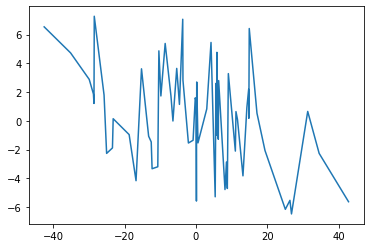

In [59]:
from torchvision.utils import make_grid
samples_=samples.cpu().numpy()
sorted_index = np.argsort(samples_[:,1])
plt.plot(samples_[sorted_index,1],samples_[sorted_index,0])